In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import math 

import os
import sys
import struct
import time
import pandas as pd

import pandas as pd
import seaborn as sns
import h5py

from tqdm import tqdm

%matplotlib inline

In [2]:
subject = "1"

In [3]:
COCO_ROOT = '/gpfs01/bartels/user/hbhatnagar/coco/panoptic_annotations_trainval2017'
NSD_ROOT  = "/gpfs01/bartels/user/hbhatnagar/NSD_dataset/"
STIM_ROOT  = NSD_ROOT + "nsddata_stimuli/stimuli/nsd/"


stim_file = STIM_ROOT + "nsd_stimuli.hdf5"
exp_design_file = NSD_ROOT + "nsddata/experiments/nsd/nsd_expdesign.mat"
nsd_stiminfo_file = '/gpfs01/bartels/user/hbhatnagar/NSD_dataset/nsddata/experiments/nsd/nsd_stim_info_merged.pkl'

PRF_PATH = NSD_ROOT+'nsddata/ppdata/' 
DATA_PATH = "/gpfs01/bartels/user/hbhatnagar/nsd-static-saliency/data"
BETAS_PATH = NSD_ROOT+f"/nsddata_betas/ppdata/subj0{subject}/func1pt8mm/betas_fithrf_GLMdenoise_RR/"
BEHAV_PATH = NSD_ROOT + f"/nsddata/ppdata/subj0{subject}/behav/responses.tsv"


DEVICE = 'cpu'

Currently  our correlation-based metric _underestimates_ the amount of variance explained, because we correlate predicted and observed betas across all trials; including image repetitions. 

The voxel response, however, will be different for each repetition due to noise. We can minimize the noise if we take the average of the betas across repetitions for each image. 


Now we compute the metric across all unique images (because they are all mean betas). that is the kind of variance that our model tries to explain.

In [4]:
resp_subj1 = pd.read_csv(BEHAV_PATH, sep ='\t')
resp_subj1['73KID'] =  resp_subj1['73KID'] - 1
resp_subj1['10KID'] = resp_subj1['10KID'] -  1
resp_subj1

,SUBJECT,SESSION,RUN,TRIAL,73KID,10KID,TIME,ISOLD,ISCORRECT,RT,CHANGEMIND,MEMORYRECENT,MEMORYFIRST,ISOLDCURRENT,ISCORRECTCURRENT,TOTAL1,TOTAL2,BUTTON,MISSINGDATA
0,1,1,1,1,46002,625,0.505082,0,1.0,803.529781,0.0,NaN,NaN,0,1.0,1,0,1.0,0
1,1,1,1,2,61882,5012,0.505128,0,1.0,972.261383,0.0,NaN,NaN,0,1.0,1,0,1.0,0
2,1,1,1,3,828,4849,0.505175,0,1.0,742.351236,0.0,NaN,NaN,0,1.0,1,0,1.0,0
3,1,1,1,4,67573,8822,0.505221,0,1.0,747.518479,0.0,NaN,NaN,0,1.0,1,0,1.0,0
4,1,1,1,5,16020,9537,0.505267,0,1.0,547.422774,0.0,NaN,NaN,0,1.0,1,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1,40,12,58,13773,8983,262.629551,1,0.0,1275.300175,0.0,20963.0,21540.0,0,1.0,1,0,1.0,0
29996,1,40,12,59,66767,6025,262.629597,1,1.0,661.379768,0.0,16.0,17622.0,1,1.0,0,1,2.0,0
29997,1,40,12,60,53167,4840,262.629644,1,1.0,786.811781,0.0,9483.0,11912.0,0,0.0,0,1,2.0,0
29998,1,40,12,61,1943,7322,262.629690,1,1.0,502.626801,0.0,83.0,12162.0,1,1.0,0,1,2.0,0


In [5]:
img_indices = resp_subj1['73KID']

In [6]:
# get for each imagae the unqiue indices when they were shown ,since each image was shown 3 times -> we will have 3 indices for each image index

grouped = resp_subj1.groupby('73KID')

result = [] 

for img_idx, group in grouped:
    indices  = group.index.tolist()
    
    sessions = group['SESSION'].tolist()
    runs = group['RUN'].tolist()
    trials = group['TRIAL'].tolist()
    
    for index, session, run, trial in zip(indices, sessions, runs, trials):
        
        result.append({
            'img_idx': img_idx, 
            'session': session,
            'run': run,
            'trial': trial,
            'original_idx': index, 
        })
    
avg_df_subj1 = pd.DataFrame(result)


In [7]:
avg_df_subj1

,img_idx,session,run,trial,original_idx
0,13,2,2,29,841
1,13,24,6,33,17595
2,13,24,10,24,17836
3,27,5,4,18,3205
4,27,23,7,49,16923
...,...,...,...,...,...
29995,72992,9,7,50,6424
29996,72992,10,2,35,6847
29997,72999,22,8,18,16205
29998,72999,30,11,14,22388


In [8]:
avg_df_subj1_dict = {}

# Iterate through rows of the DataFrame and populate the dictionary
for row in avg_df_subj1.itertuples():
    img_idx = row.img_idx
    original_index = row.original_idx
    
    # Check if img_idx is already a key in the dictionary
    if img_idx in avg_df_subj1_dict:
        avg_df_subj1_dict[img_idx].append(original_index)
    else:
        avg_df_subj1_dict[img_idx] = [original_index]

In [9]:
avg_df_subj1_dict[46002]

[0, 12802, 25836]

In [10]:
avg_df_subj1_dict[845]

# These are the indices which we need to average, in the concatenated betas matrix 

[27948, 28063, 28291]

# Averaging the betas across images 

In [11]:
import pickle 

with open(DATA_PATH+'/num_voxel_rois_dict.pkl', 'rb') as fp: 
    num_voxel_rois_dict = pickle.load(fp)
    print(num_voxel_rois_dict)

{'v1': 7887, 'v2': 8296, 'v3': 7022, 'v4': 3976, 'ofa': 2077, 'ffa1': 2854, 'ffa2': 1823, 'atl': 935, 'eba': 17406, 'fba1': 2294, 'fba2': 2539, 'opa': 9393, 'ppa': 5927, 'rsc': 3360, 'owfa': 2701, 'vwfa_1': 4671, 'vwfa_2': 3009, 'mfs_words': 973, 'mtl_words': 675, 'vo1': 1263, 'vo2': 1839, 'phc1': 1141, 'phc2': 1032, 'mst': 303, 'hmt': 1665, 'lo2': 1099, 'lo1': 1966, 'v3b': 1830, 'v3a': 3957, 'ips0': 3450, 'ips1': 2755, 'ips2': 2969, 'ips3': 2960, 'ips4': 361, 'ips5': 72, 'spl1': 941, 'fef': 410}


In [12]:
NUM_SESSIONS = 37

In [13]:
import os 
import fnmatch

In [14]:
def gen_avg_betas(roi):
    
    betas_full_file_name = f"betas_full_{roi}.npy"
    betas_file = np.load(DATA_PATH+f"/{betas_full_file_name}")
    betas_file = betas_file[1:,:] # remove the first dummy row 
    
    num_voxels = num_voxel_rois_dict[roi]
                                     
    beta_avg = [] 
    
    # orig_idx = [] 
    
    imgs_done = {}
    
    for idx, img_idx in enumerate(tqdm(img_indices)):
        
        # if the image has already been averaged, skip it 
        if img_idx in imgs_done:
            continue
        
        list_of_indices = avg_df_subj1_dict[img_idx]
        
        # filter out of bound indices 
        valid_indices = [i for i in list_of_indices if i < betas_file.shape[0]]
        
        group_average = np.mean(betas_file[valid_indices], axis = 0) 

        
        beta_avg.append(group_average)
        # orig_idx.append(img_idx) 
        
        imgs_done[img_idx] = img_idx # add to a dict that can then skip the averaging again 
    
    return np.array(beta_avg)
        
        

In [15]:
beta_avg_v1 = gen_avg_betas('v1')

 91%|█████████ | 27208/30000 [00:01<00:00, 30220.50it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:01<00:00, 18607.63it/s]


In [16]:
beta_avg_v1

array([[-0.68048474,  0.27007251, -0.08545868, ...,  0.79991264,
        -0.65290633, -0.01317169],
       [-0.77941106, -0.46458636, -0.32235219, ..., -0.07945126,
        -0.39616856, -0.58416185],
       [ 0.52492907,  0.12169994, -0.38596312, ..., -0.0202311 ,
        -0.24755049, -0.19825248],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [17]:
beta_avg_v1.shape


(10000, 7887)

In [18]:
# check out of bounds images 
# images where ALL of the indices are out of bounds for the betas 

roi = 'v1'

betas_full_file_name = f"betas_full_{roi}.npy"
betas_file = np.load(DATA_PATH+f"/{betas_full_file_name}")
betas_file = betas_file[1:,:] 

oob_images = [] 

for img_idx, indices in avg_df_subj1_dict.items(): 
    all_out_of_bounds = all( i >= betas_file.shape[0] for i in indices) 
    
    if all_out_of_bounds: 
        # print(f"Image {img_idx} is OOB")
        oob_images.append(img_idx) 

In [19]:
len(oob_images)

159

In [20]:
def save_averaged_betas_all_roi(roi_list, path):
    for roi in roi_list: 
        print(f"Averaging for {roi}")
        avg_betas = gen_avg_betas(roi)
        file_name = f"betas_full_avg_{roi}.npy"
        
        np.save(path+file_name, avg_betas)
        print(f"Successfully saved {roi} betas to disk")
        

In [21]:
roi_list = ["v1","v2","v3","v4",
            "ofa","ffa1", "ffa2", "atl",
            "eba","fba1", "fba2",
            "opa", "ppa", "rsc",
            "owfa", "vwfa_1", "vwfa_2", "mfs_words", "mtl_words",

            "vo1","vo2","phc1","phc2","mst","hmt","lo2","lo1",
            "v3b","v3a","ips0","ips1","ips2","ips3","ips4",
            "ips5","spl1","fef"]

averaged_beta_files_path = f"{DATA_PATH}/averaged_beta_files/"

In [30]:
save_averaged_betas_all_roi(roi_list, averaged_beta_files_path) 

Averaging for v1


100%|██████████| 30000/30000 [00:00<00:00, 51705.87it/s]


Successfully saved v1 betas to disk
Averaging for v2


100%|██████████| 30000/30000 [00:00<00:00, 50515.14it/s]


Successfully saved v2 betas to disk
Averaging for v3


100%|██████████| 30000/30000 [00:00<00:00, 59444.85it/s]


Successfully saved v3 betas to disk
Averaging for v4


100%|██████████| 30000/30000 [00:00<00:00, 85275.16it/s]


Successfully saved v4 betas to disk
Averaging for ofa


100%|██████████| 30000/30000 [00:00<00:00, 108757.74it/s]


Successfully saved ofa betas to disk
Averaging for ffa1


100%|██████████| 30000/30000 [00:00<00:00, 102204.21it/s]


Successfully saved ffa1 betas to disk
Averaging for ffa2


100%|██████████| 30000/30000 [00:00<00:00, 117436.96it/s]


Successfully saved ffa2 betas to disk
Averaging for atl


100%|██████████| 30000/30000 [00:00<00:00, 129439.05it/s]


Successfully saved atl betas to disk
Averaging for eba


100%|██████████| 30000/30000 [00:01<00:00, 17851.50it/s]


Successfully saved eba betas to disk
Averaging for fba1


100%|██████████| 30000/30000 [00:00<00:00, 86658.40it/s]


Successfully saved fba1 betas to disk
Averaging for fba2


100%|██████████| 30000/30000 [00:00<00:00, 98271.52it/s] 


Successfully saved fba2 betas to disk
Averaging for opa


100%|██████████| 30000/30000 [00:00<00:00, 34304.88it/s]


Successfully saved opa betas to disk
Averaging for ppa


100%|██████████| 30000/30000 [00:00<00:00, 46103.43it/s]


Successfully saved ppa betas to disk
Averaging for rsc


100%|██████████| 30000/30000 [00:00<00:00, 95554.35it/s]


Successfully saved rsc betas to disk
Averaging for owfa


100%|██████████| 30000/30000 [00:00<00:00, 95808.34it/s]


Successfully saved owfa betas to disk
Averaging for vwfa_1


100%|██████████| 30000/30000 [00:00<00:00, 68487.86it/s]


Successfully saved vwfa_1 betas to disk
Averaging for vwfa_2


100%|██████████| 30000/30000 [00:00<00:00, 93523.63it/s]


Successfully saved vwfa_2 betas to disk
Averaging for mfs_words


100%|██████████| 30000/30000 [00:00<00:00, 144504.61it/s]


Successfully saved mfs_words betas to disk
Averaging for mtl_words


100%|██████████| 30000/30000 [00:00<00:00, 143245.15it/s]


Successfully saved mtl_words betas to disk
Averaging for vo1


100%|██████████| 30000/30000 [00:00<00:00, 117898.45it/s]


Successfully saved vo1 betas to disk
Averaging for vo2


100%|██████████| 30000/30000 [00:00<00:00, 117914.02it/s]


Successfully saved vo2 betas to disk
Averaging for phc1


100%|██████████| 30000/30000 [00:00<00:00, 121999.32it/s]


Successfully saved phc1 betas to disk
Averaging for phc2


100%|██████████| 30000/30000 [00:00<00:00, 136572.46it/s]


Successfully saved phc2 betas to disk
Averaging for mst


100%|██████████| 30000/30000 [00:00<00:00, 153192.33it/s]


Successfully saved mst betas to disk
Averaging for hmt


100%|██████████| 30000/30000 [00:00<00:00, 113422.41it/s]


Successfully saved hmt betas to disk
Averaging for lo2


100%|██████████| 30000/30000 [00:00<00:00, 128454.08it/s]


Successfully saved lo2 betas to disk
Averaging for lo1


100%|██████████| 30000/30000 [00:00<00:00, 103564.51it/s]


Successfully saved lo1 betas to disk
Averaging for v3b


100%|██████████| 30000/30000 [00:00<00:00, 105871.85it/s]


Successfully saved v3b betas to disk
Averaging for v3a


100%|██████████| 30000/30000 [00:00<00:00, 80982.48it/s]


Successfully saved v3a betas to disk
Averaging for ips0


100%|██████████| 30000/30000 [00:00<00:00, 86960.96it/s]


Successfully saved ips0 betas to disk
Averaging for ips1


100%|██████████| 30000/30000 [00:00<00:00, 99401.53it/s] 


Successfully saved ips1 betas to disk
Averaging for ips2


100%|██████████| 30000/30000 [00:00<00:00, 85827.21it/s]


Successfully saved ips2 betas to disk
Averaging for ips3


100%|██████████| 30000/30000 [00:00<00:00, 91520.87it/s]


Successfully saved ips3 betas to disk
Averaging for ips4


100%|██████████| 30000/30000 [00:00<00:00, 148044.36it/s]


Successfully saved ips4 betas to disk
Averaging for ips5


100%|██████████| 30000/30000 [00:00<00:00, 188356.51it/s]


Successfully saved ips5 betas to disk
Averaging for spl1


100%|██████████| 30000/30000 [00:00<00:00, 125807.61it/s]


Successfully saved spl1 betas to disk
Averaging for fef


100%|██████████| 30000/30000 [00:00<00:00, 161916.61it/s]


Successfully saved fef betas to disk


In [165]:
def gen_avg_sal_maps(S_mat_type):
    
    num_pixels = 425 
    num_images = 30000
    
    file_mapping = {
        'deepgaze': "S_mat_full_batched.npy",
        'edges': "S_mat_edges.npy",
        'luminance': "S_mat_luminance.npy",
        'saturation': "S_mat_saturation.npy",
        'ittikoch': "salmaps_all.mat",
        'icf': "S_mat_icf.npy",
        'deepgaze2': "S_mat_deepgaze2.npy",
        'gbvs': "gbvs_all_imgs.mat",
        'deepgaze1':"S_mat_deepgaze1.npy"
    }
    
    if S_mat_type not in file_mapping:
        raise ValueError("Argument 'S_mat_type' must be one of 'deepgaze', 'edges', 'luminance', 'saturation', 'ittikoch', 'icf', 'deepgaze2','deepgaze1', or 'gbvs'.")

    S_mat_file_name = file_mapping[S_mat_type]
    
    if S_mat_type in ['ittikoch', 'gbvs']:
        maps_dataset = h5py.File(DATA_PATH + "/"+ S_mat_file_name, 'r')
        S_mat = np.copy(maps_dataset['salmaplist'])
        maps_dataset.close()
        S_mat = S_mat.reshape(num_pixels, num_pixels, num_images).transpose(1, 0, 2).reshape(-1, num_images).T
    else:
        S_mat = np.load(DATA_PATH+f"/{S_mat_file_name}")

    
    if S_mat_type == 'deepgaze':
        S_mat = S_mat[1:,:] # remove dummy row 
    
    S_mat = S_mat[:27750,:] # remove the last 3 session voxels for session 38,39 and 40 
    
    S_mat_avg = [] 
    imgs_done = {}
    
    for idx, img_idx in enumerate(tqdm(img_indices)):
        # if the image has already been averaged, skip it 
        if img_idx in imgs_done:
            continue
        list_of_indices = avg_df_subj1_dict[img_idx]
        
        # filter out of bound indices 
        valid_indices = [i for i in list_of_indices if i < S_mat.shape[0]]
        group_average = np.mean(S_mat[valid_indices], axis = 0) 
        S_mat_avg.append(group_average)
        imgs_done[img_idx] = img_idx # add to a dict that can then skip the averaging again 
    
    return np.array(S_mat_avg)
        

In [23]:
S_mat_averaged = gen_avg_sal_maps('deepgaze')

 91%|█████████▏| 27385/30000 [00:32<00:00, 2952.49it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:33<00:00, 903.98it/s] 


In [24]:
S_mat_averaged

array([[[-17.56979187, -17.56979187, -17.56979187, ..., -21.75280521,
         -22.06371472, -22.06371472],
        [-17.56979187, -17.56979187, -17.56979187, ..., -21.75280521,
         -22.06371472, -22.06371472],
        [-17.56979187, -17.56979187, -17.56979187, ..., -21.75280521,
         -22.06371472, -22.06371472],
        ...,
        [-17.74727829, -17.74727829, -17.74727829, ..., -17.74911501,
         -17.88831232, -17.88831232],
        [-17.8627866 , -17.8627866 , -17.8627866 , ..., -17.75817821,
         -17.89992529, -17.89992529],
        [-17.8627866 , -17.8627866 , -17.8627866 , ..., -17.75817821,
         -17.89992529, -17.89992529]],

       [[-17.77345169, -17.77345169, -17.77345169, ..., -21.88932844,
         -22.20205622, -22.20205622],
        [-17.77345169, -17.77345169, -17.77345169, ..., -21.88932844,
         -22.20205622, -22.20205622],
        [-17.77345169, -17.77345169, -17.77345169, ..., -21.88932844,
         -22.20205622, -22.20205622],
        ...,


In [25]:
S_mat_averaged.shape

(10000, 425, 425)

In [26]:
# np.save(averaged_beta_files_path+"S_mat_averaged", S_mat_averaged)

# Correlations with averaged betas

In [27]:
beta_avg_v1.shape

(10000, 7887)

In [28]:
nan_rows = np.isnan(beta_avg_v1).any(axis = 1) 
beta_wo_nan_v1 = beta_avg_v1[~nan_rows]

In [29]:
beta_wo_nan_v1.shape

(9841, 7887)

In [30]:
def gen_corr_w_beta(roi, print_log, S_mat):
    
    num_pixels = 425 
    
    print(f"Computing correlation for {roi}\n")

    K_mat = np.load(DATA_PATH+f"/K_mat_subj1_{roi}.npy.npz")
    K_mat = K_mat['arr_0']
   
    if print_log: 
        print(f"K matrix: {K_mat.shape}")
    
    betas_mat = np.load(averaged_beta_files_path+f"/betas_full_avg_{roi}.npy")
          
    roi_valid_indices = np.load(DATA_PATH+f"/{roi}_valid_indices_subj{subject}.npy")
   
    if print_log: 
        print(f"Betas matrix before valid: {betas_mat.shape}")
        print(f"Valid indices shape: {roi_valid_indices.shape}")
    
    # index the betas for the corresponding voxels that are valid 
    betas_val = betas_mat[:,roi_valid_indices] 
    
    
    # betas_val = betas_val[1:,:] # remove the first dummy row 
    if print_log: 
        print(f"Betas matrix: {betas_val.shape}")
    
    if S_mat.ndim !=2: # This means that the S_mat has not been unrolled 
        S_mat = S_mat.reshape(-1, num_pixels * num_pixels)
        
    # Remove NaN rows if present from both Betas and S_mat
    nan_rows = np.isnan(betas_val).any(axis = 1) 
    betas_val = betas_val[~nan_rows]
    S_mat = S_mat[~nan_rows]
    
    if print_log: 
        print(f"Betas matrix after nan removal: {betas_val.shape}")
    
    
    Y_hat = S_mat @ K_mat.T
    if print_log:
        print(f"Y_hat matrix: {Y_hat.shape}\n\n")      
    
    # Correlate between betas_valid and Y_hat 
    corr_mat = np.corrcoef(betas_val,Y_hat,rowvar = False) # Example: (27750, 4165) x (27750, 4165) for V1 

    return corr_mat

In [31]:
# corr_mat_v1 = gen_corr_w_beta(roi = 'v1', print_log = True, S_mat = S_mat_averaged)

In [32]:
def generate_corr_full(roi_list, S_mat, print_log = False):
    '''
    Generate the correlation coeff for the given list of ROIs and return it as a dataframe 
    '''
    corr_vals = {}
    
    for roi in roi_list:
        corr_mat_roi = gen_corr_w_beta(roi = roi, S_mat = S_mat, print_log = print_log) 
        rel_size = (corr_mat_roi.shape[0])// 2
        corr_mat_rel_roi = corr_mat_roi[rel_size:,:rel_size]
        corr_vals[roi] = corr_mat_rel_roi.diagonal() 
        
    
    # Create a main dataframe to which all smaller dataframes (for each ROI) will be appended 
    df_main = pd.DataFrame(columns = ['ROI','corr_coeff'])
    
    for key,val in corr_vals.items(): # Key: ROI, value: array of correlations
        roi_as_list = [key] * val.shape[0] # duplicate the roi string so that it's in the format we want 
        corr_val_list = val
        temp_df = pd.DataFrame({'ROI': roi_as_list, 'corr_coeff':corr_val_list})   
        df_main = pd.concat((df_main, temp_df))
        
    return df_main

In [33]:
viz_roi_list = ["v1","v2","v3","v4"]
floc_faces_roi_list = ["ofa","ffa1", "ffa2", "atl"]
floc_words_roi_list = ["eba","fba1", "fba2"]
floc_places_roi_list = ["opa", "ppa", "rsc"]
floc_bodies_roi_list = ["owfa", "vwfa_1", "vwfa_2", "mfs_words", "mtl_words"]

ventral_temporal_roi_list = ["vo1","vo2","phc1","phc2"]
dorso_lateral_roi_list = ["v3a","v3b","lo2","lo1"]
pareital_frontal_roi_list = ["ips0","ips1","ips2","ips3","ips4","ips5","spl1","fef"]

list_a = ["v3a","v3b", "ips0","ips1","ips2","ips3","ips4","ips5", "spl1","fef"]
list_b = ["vo1","vo2","lo1","lo2","phc1","phc2"]


In [34]:
corr_df_viz = generate_corr_full(roi_list = viz_roi_list,S_mat =  S_mat_averaged)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



In [35]:
sns.set_style("whitegrid")


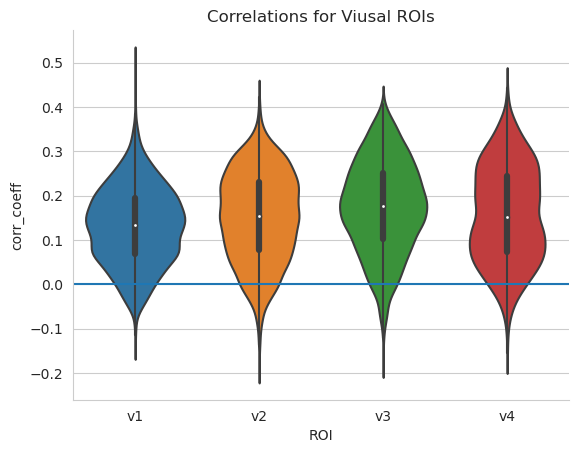

In [36]:
g = sns.violinplot(data = corr_df_viz, x = "ROI" , y = "corr_coeff")
sns.despine()
g.axhline(0)
g.set(title = 'Correlations for Viusal ROIs');

## Plot previous graphs 

### DeepGaze IIE

In [127]:
def concat_df_with_type(df_list , type_list):
    '''
    Concatenate the corr dataframes such that they each have a colunn 'type' which contains the type of the data. 
    Such as DeepGaze, edge, lumninance, etc.
    
    '''
    # older 
#     df_main = pd.DataFrame(columns = ['ROI','corr_coeff', 'type'])
    
#     for df, corr_type in zip(df_list, type_list):
#         df_copy = df.copy()
#         df_copy['type'] = corr_type
#         df_main = df_main.append(df_copy)

    # Create a list of DataFrames with the 'type' column added
    dfs_with_type = [df.assign(type=corr_type) for df, corr_type in zip(df_list, type_list)]
    
    # Concatenate the list of DataFrames into a single DataFrame
    df_main = pd.concat(dfs_with_type, ignore_index=True)
    
    
    return df_main

In [38]:
corr_df_faces = generate_corr_full(roi_list = floc_faces_roi_list, S_mat = S_mat_averaged)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [39]:
corr_df_words = generate_corr_full(roi_list = floc_words_roi_list, S_mat = S_mat_averaged)

Computing correlation for eba

Computing correlation for fba1

Computing correlation for fba2



In [40]:
corr_df_places = generate_corr_full(roi_list = floc_places_roi_list, S_mat = S_mat_averaged)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



In [41]:
corr_df_bodies = generate_corr_full(roi_list = floc_bodies_roi_list, S_mat = S_mat_averaged)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



In [42]:
corr_df_list_a = generate_corr_full(roi_list = list_a, S_mat = S_mat_averaged)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



In [43]:
corr_df_list_b = generate_corr_full(roi_list = list_b, S_mat = S_mat_averaged)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



In [51]:
corr_dfs_deepgaze = {} 

corr_dfs_deepgaze['viz'] = corr_df_viz
corr_dfs_deepgaze['faces'] = corr_df_faces
corr_dfs_deepgaze['words'] = corr_df_words
corr_dfs_deepgaze['places']= corr_df_places
corr_dfs_deepgaze['bodies']= corr_df_bodies
corr_dfs_deepgaze['list_a']= corr_df_list_a
corr_dfs_deepgaze['list_b']= corr_df_list_b

In [54]:
DATA_PATH

'/gpfs01/bartels/user/hbhatnagar/nsd-static-saliency/data'

In [55]:
import pickle
pickle.dump(corr_dfs_deepgaze, open(f"{DATA_PATH}/corr_dictionaries/corr_dfs_deepgaze.pkl", "wb"))

### Edges 

In [44]:
S_mat_edges_averaged = gen_avg_sal_maps('edges')

 92%|█████████▏| 27583/30000 [00:50<00:00, 2420.26it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:50<00:00, 590.47it/s] 


In [45]:
# np.save(averaged_beta_files_path+"S_mat_edges_averaged", S_mat_edges_averaged)

In [46]:
corr_df_viz_edges = generate_corr_full(viz_roi_list, S_mat_edges_averaged)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



In [47]:
corr_df_faces_edges = generate_corr_full(floc_faces_roi_list, S_mat_edges_averaged, print_log = False)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [48]:
corr_df_words_edges = generate_corr_full(floc_words_roi_list, S_mat_edges_averaged, print_log = False)

Computing correlation for eba

Computing correlation for fba1

Computing correlation for fba2



In [57]:
corr_df_places_edges = generate_corr_full(floc_places_roi_list, S_mat_edges_averaged, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



In [58]:
corr_df_bodies_edges = generate_corr_full(floc_bodies_roi_list, S_mat_edges_averaged, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



In [59]:
corr_df_listA_edges = generate_corr_full(list_a, S_mat_edges_averaged, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



In [60]:
corr_df_listB_edges = generate_corr_full(list_b, S_mat_edges_averaged, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



In [112]:
corr_dfs_edges = {} 

corr_dfs_edges['viz'] = corr_df_viz_edges
corr_dfs_edges['faces'] = corr_df_faces_edges
corr_dfs_edges['words'] = corr_df_words_edges
corr_dfs_edges['places']= corr_df_places_edges
corr_dfs_edges['bodies']= corr_df_bodies_edges
corr_dfs_edges['list_a']= corr_df_listA_edges
corr_dfs_edges['list_b']= corr_df_listB_edges

pickle.dump(corr_dfs_edges, open(f"{DATA_PATH}/corr_dictionaries/corr_dfs_edges.pkl", "wb"))

### Saturation and Luminance

In [62]:
S_mat_saturation_averaged = gen_avg_sal_maps('saturation')
S_mat_luminance_averaged = gen_avg_sal_maps('luminance')


 91%|█████████ | 27313/30000 [00:31<00:00, 3062.80it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:29<00:00, 1006.63it/s]


In [63]:
# np.save(averaged_beta_files_path+"S_mat_saturation_averaged", S_mat_saturation_averaged)

In [64]:
# np.save(averaged_beta_files_path+"S_mat_luminance_averaged", S_mat_luminance_averaged)

In [65]:
corr_df_viz_saturation = generate_corr_full(viz_roi_list,S_mat_saturation_averaged, print_log = False)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



In [66]:
corr_df_viz_luminance = generate_corr_full(viz_roi_list, S_mat_luminance_averaged, print_log = False)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



In [67]:
corr_df_faces_saturation = generate_corr_full(floc_faces_roi_list,S_mat_saturation_averaged, print_log = False)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [68]:
corr_df_faces_luminance = generate_corr_full(floc_faces_roi_list, S_mat_luminance_averaged, print_log = False)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [69]:
corr_df_bodies_saturation = generate_corr_full(floc_bodies_roi_list,S_mat_saturation_averaged, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



In [70]:
corr_df_bodies_luminance = generate_corr_full(floc_bodies_roi_list, S_mat_luminance_averaged, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



In [71]:
corr_df_places_saturation = generate_corr_full(floc_places_roi_list,S_mat_saturation_averaged, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



In [72]:
corr_df_places_luminance = generate_corr_full(floc_places_roi_list, S_mat_luminance_averaged, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



In [73]:
corr_df_words_saturation = generate_corr_full(floc_words_roi_list,S_mat_saturation_averaged, print_log = False)

Computing correlation for eba

Computing correlation for fba1

Computing correlation for fba2



In [74]:
corr_df_words_luminance = generate_corr_full(floc_words_roi_list, S_mat_luminance_averaged, print_log = False)

Computing correlation for eba

Computing correlation for fba1

Computing correlation for fba2



In [75]:
corr_df_listA_saturation = generate_corr_full(list_a, S_mat_saturation_averaged, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



In [76]:
corr_df_listA_luminance = generate_corr_full(list_a, S_mat_luminance_averaged, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



In [77]:
corr_df_listB_saturation = generate_corr_full(list_b, S_mat_saturation_averaged, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



In [78]:
corr_df_listB_luminance = generate_corr_full(list_b, S_mat_luminance_averaged, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



In [110]:
corr_dfs_saturation = {} 

corr_dfs_saturation['viz'] = corr_df_viz_saturation
corr_dfs_saturation['faces'] = corr_df_faces_saturation
corr_dfs_saturation['words'] = corr_df_words_saturation
corr_dfs_saturation['places']= corr_df_places_saturation
corr_dfs_saturation['bodies']= corr_df_bodies_saturation
corr_dfs_saturation['list_a']= corr_df_listA_saturation
corr_dfs_saturation['list_b']= corr_df_listB_saturation

pickle.dump(corr_dfs_saturation, open(f"{DATA_PATH}/corr_dictionaries/corr_dfs_saturation.pkl", "wb"))

In [111]:
corr_dfs_luminance = {} 

corr_dfs_luminance['viz'] = corr_df_viz_luminance
corr_dfs_luminance['faces'] = corr_df_faces_luminance
corr_dfs_luminance['words'] = corr_df_words_luminance
corr_dfs_luminance['places']= corr_df_places_luminance
corr_dfs_luminance['bodies']= corr_df_bodies_luminance
corr_dfs_luminance['list_a']= corr_df_listA_luminance
corr_dfs_luminance['list_b']= corr_df_listB_luminance

pickle.dump(corr_dfs_luminance, open(f"{DATA_PATH}/corr_dictionaries/corr_dfs_luminance.pkl", "wb"))

### Itti and Koch 

In [80]:
S_mat_ittikoch_averaged  = gen_avg_sal_maps('ittikoch')

 92%|█████████▏| 27656/30000 [03:13<00:02, 1097.85it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [03:13<00:00, 155.24it/s] 


In [81]:
# np.save(averaged_beta_files_path+"S_mat_ittikoch_averaged", S_mat_ittikoch_averaged)

In [82]:
corr_df_viz_itti = generate_corr_full(viz_roi_list, S_mat_ittikoch_averaged, print_log = False)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



In [178]:
def plot_corr_violinplot(df , hue_order = None, title = "Correlation" , palette = "Pastel1"):
    g = sns.violinplot(data = df, x = "ROI" , y = "corr_coeff", hue = "type", palette = palette, hue_order = hue_order)
    sns.despine()
    g.axhline(0)
    g.set(title = title);
    

/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

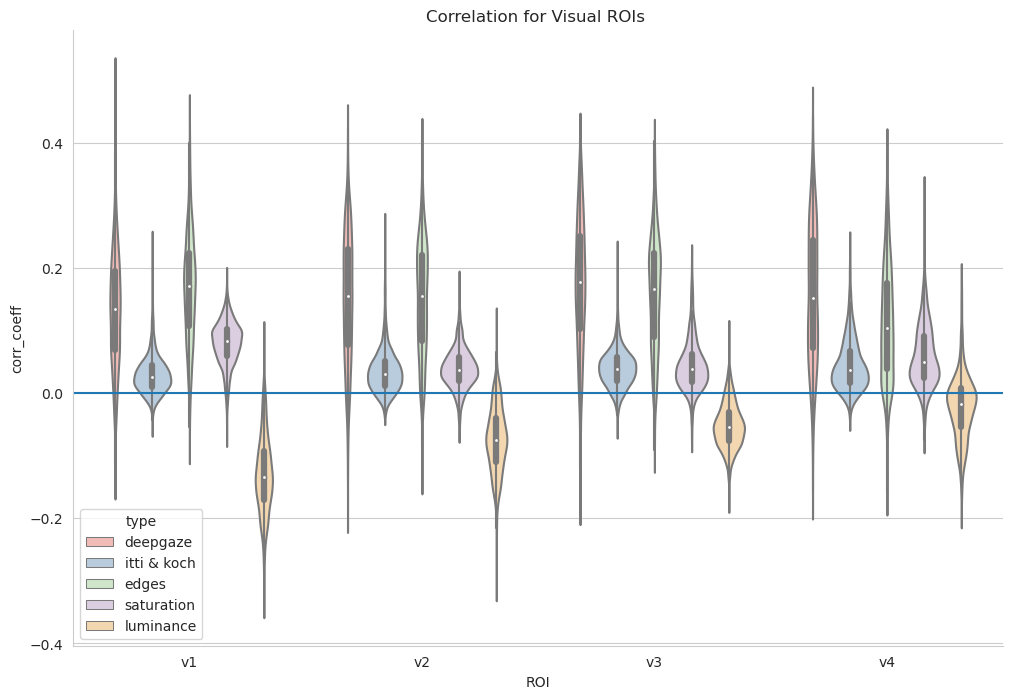

In [84]:
plt.figure(figsize=(12, 8))

plot_corr_violinplot(df = concat_df_with_type(
                          df_list = [corr_df_viz, corr_df_viz_itti, corr_df_viz_edges, corr_df_viz_saturation, corr_df_viz_luminance],
                        type_list = ["deepgaze", "itti & koch" , "edges", "saturation", "luminance"]),                   
                            title = "Correlation for Visual ROIs ")

In [85]:
corr_df_faces_itti = generate_corr_full(floc_faces_roi_list, S_mat_ittikoch_averaged, print_log = False)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

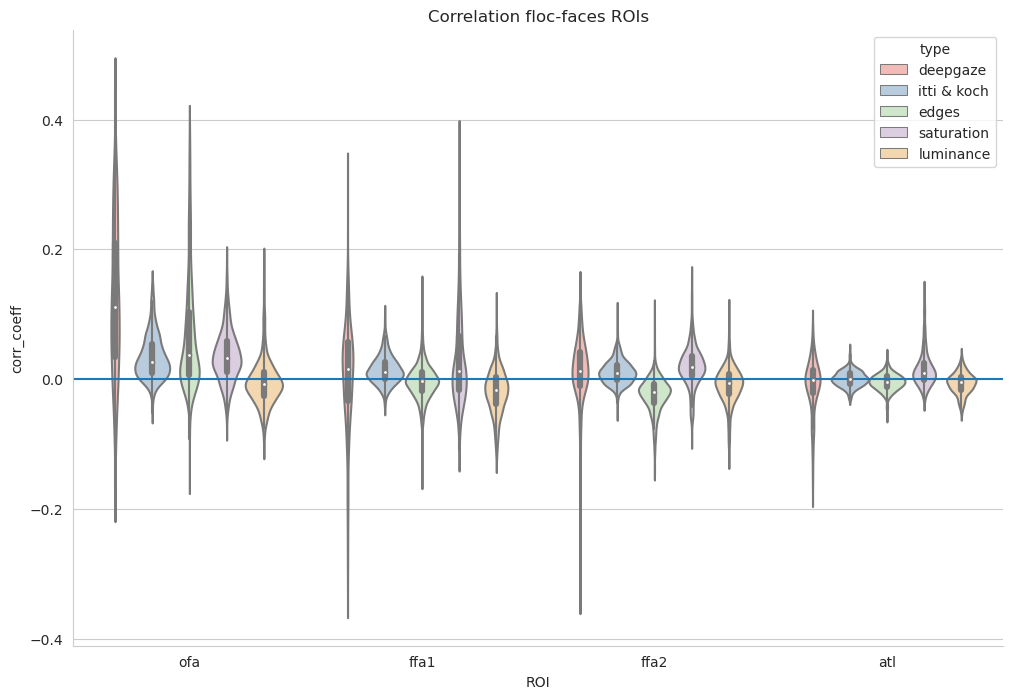

In [86]:
plt.figure(figsize=(12, 8))

plot_corr_violinplot(df = concat_df_with_type(
                        df_list = [corr_df_faces, corr_df_faces_itti, corr_df_faces_edges, corr_df_faces_saturation, corr_df_faces_luminance],
                      type_list = ["deepgaze", "itti & koch", "edges", "saturation", "luminance"]),                   
                          title = "Correlation floc-faces ROIs")

In [87]:
corr_df_bodies_itti = generate_corr_full(floc_bodies_roi_list, S_mat_ittikoch_averaged, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

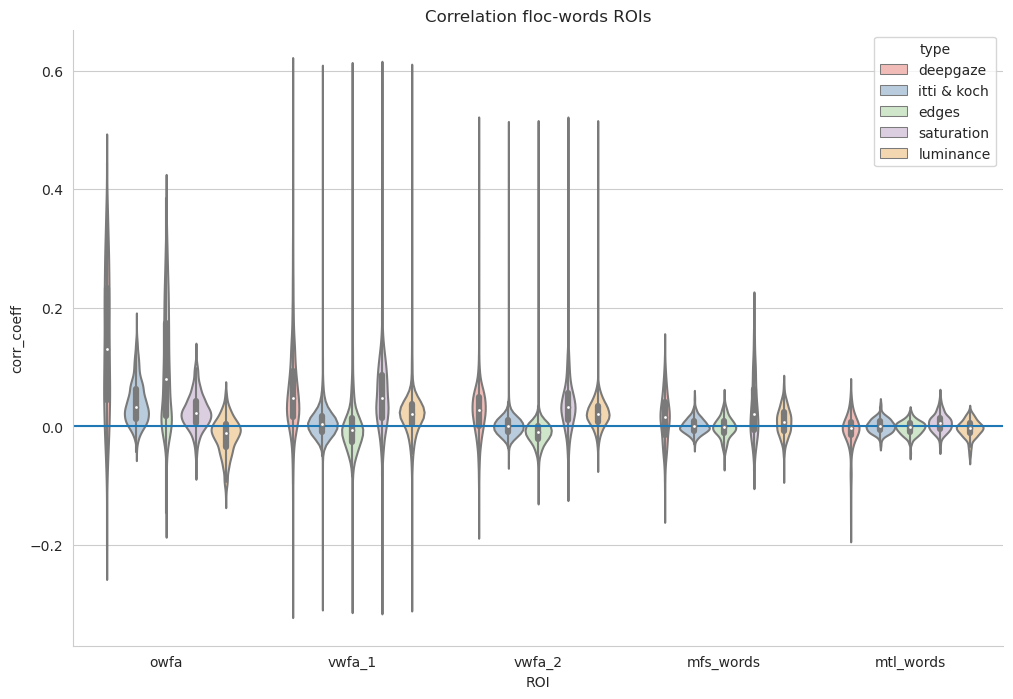

In [88]:
plt.figure(figsize=(12, 8))

plot_corr_violinplot(df = concat_df_with_type(
                    df_list = [corr_df_bodies, corr_df_bodies_itti, corr_df_bodies_edges, corr_df_bodies_saturation, corr_df_bodies_luminance],
                  type_list = ["deepgaze", "itti & koch", "edges", "saturation", "luminance"]),                   
                      title = "Correlation floc-words ROIs")

In [89]:
corr_df_places_itti = generate_corr_full(floc_places_roi_list, S_mat_ittikoch_averaged, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

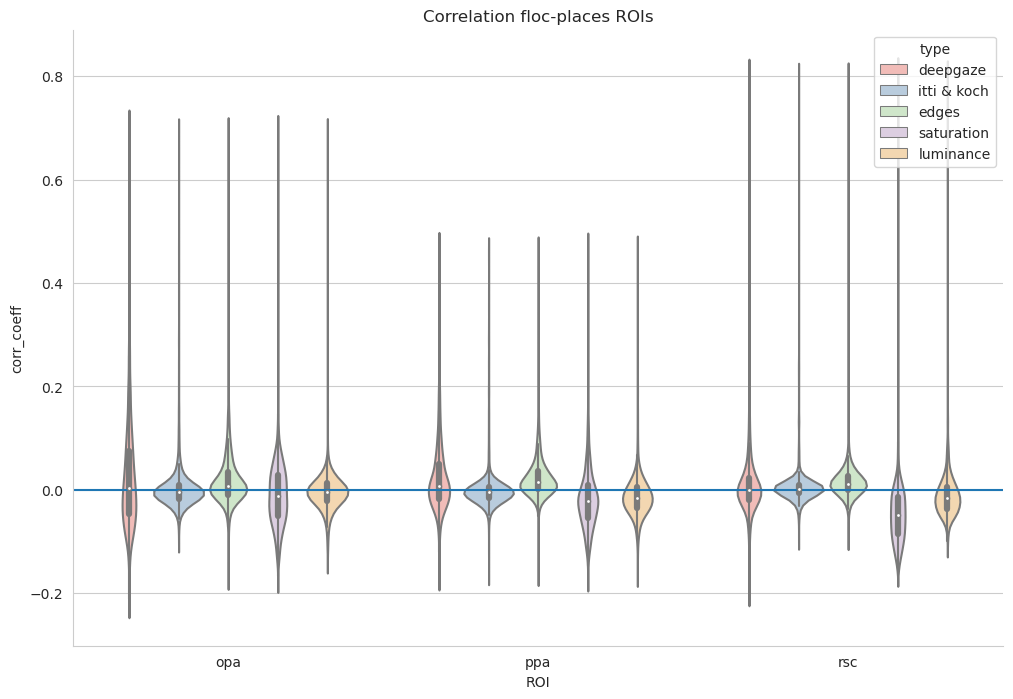

In [90]:
plt.figure(figsize=(12, 8))

plot_corr_violinplot(df = concat_df_with_type(
                    df_list = [corr_df_places, corr_df_places_itti, corr_df_places_edges, corr_df_places_saturation, corr_df_places_luminance],
                  type_list = ["deepgaze","itti & koch", "edges", "saturation", "luminance"]) ,                   
                      title = "Correlation floc-places ROIs")

In [91]:
corr_df_words_itti = generate_corr_full(floc_words_roi_list, S_mat_ittikoch_averaged, print_log = False)

Computing correlation for eba

Computing correlation for fba1

Computing correlation for fba2



/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

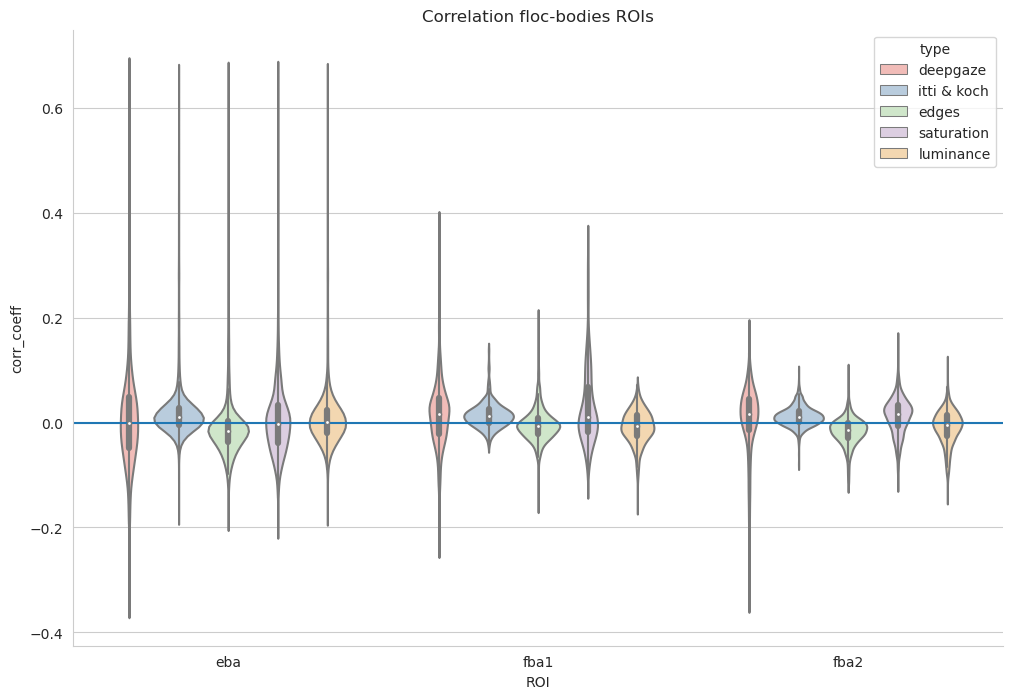

In [92]:
plt.figure(figsize=(12, 8))

plot_corr_violinplot(df = concat_df_with_type(
                    df_list = [corr_df_words, corr_df_words_itti, corr_df_words_edges, corr_df_words_saturation, corr_df_words_luminance],
                  type_list = ["deepgaze","itti & koch", "edges", "saturation", "luminance"]) ,                   
                      title = "Correlation floc-bodies ROIs")

In [93]:
corr_df_listA_itti = generate_corr_full(list_a, S_mat_ittikoch_averaged, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

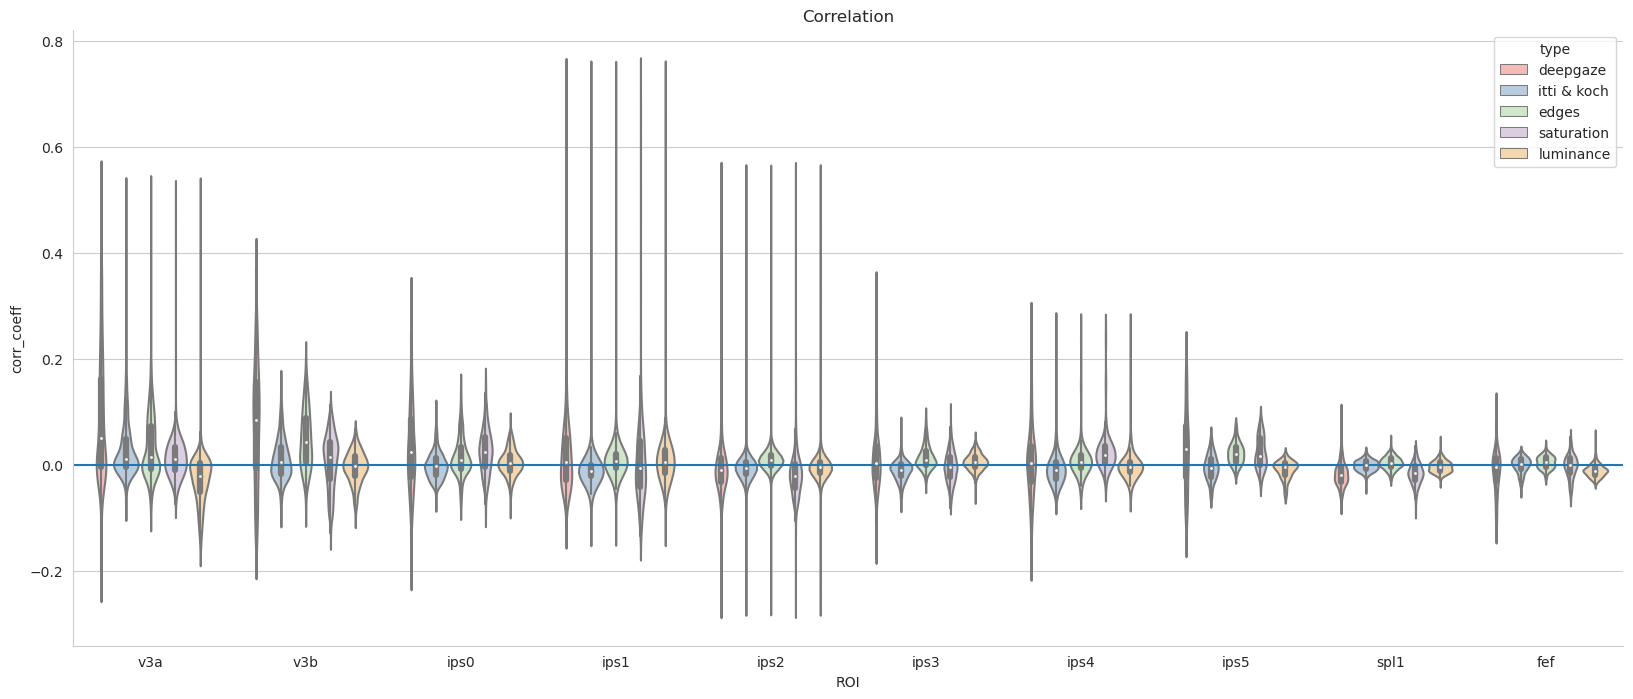

In [94]:
plt.figure(figsize=(20,8))

plot_corr_violinplot(df = concat_df_with_type(
                    df_list = [corr_df_list_a, corr_df_listA_itti, corr_df_listA_edges, corr_df_listA_saturation, corr_df_listA_luminance],
                  type_list = ["deepgaze", "itti & koch", "edges", "saturation", "luminance"]) ,                   
                      title = "Correlation")

In [95]:
corr_df_listB_itti = generate_corr_full(list_b, S_mat_ittikoch_averaged, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_72427/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

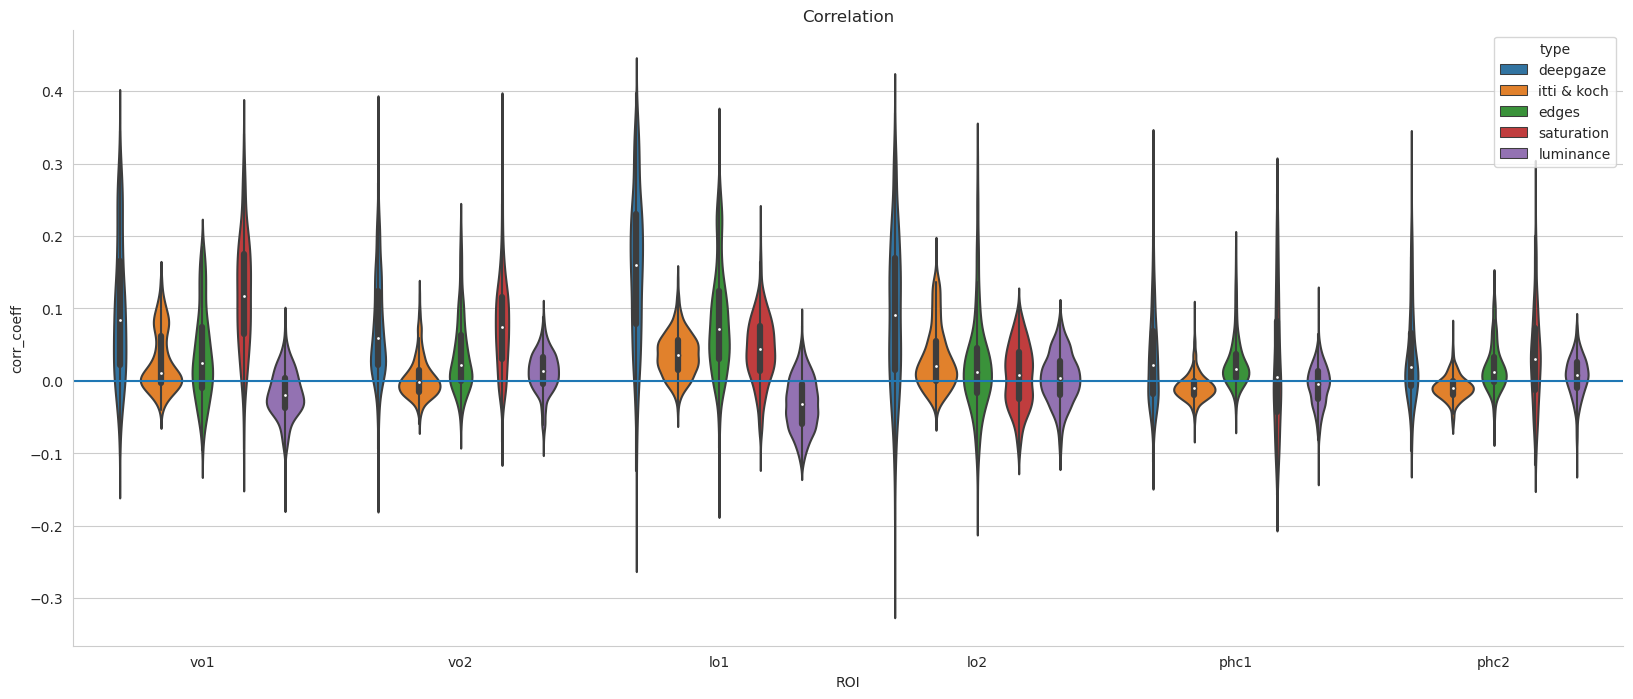

In [96]:
plt.figure(figsize=(20,8))

plot_corr_violinplot(df = concat_df_with_type(
                    df_list = [corr_df_list_b, corr_df_listB_itti, corr_df_listB_edges, corr_df_listB_saturation, corr_df_listB_luminance],
                  type_list = ["deepgaze", "itti & koch", "edges", "saturation", "luminance"]) ,                   
                      title = "Correlation",
                    palette = "tab10")

In [109]:
corr_dfs_ittikoch = {} 

corr_dfs_ittikoch['viz'] = corr_df_viz_itti
corr_dfs_ittikoch['faces'] = corr_df_faces_itti
corr_dfs_ittikoch['words'] = corr_df_words_itti
corr_dfs_ittikoch['places']= corr_df_places_itti
corr_dfs_ittikoch['bodies']= corr_df_bodies_itti
corr_dfs_ittikoch['list_a']= corr_df_listA_itti
corr_dfs_ittikoch['list_b']= corr_df_listB_itti

pickle.dump(corr_dfs_ittikoch, open(f"{DATA_PATH}/corr_dictionaries/corr_dfs_ittikoch.pkl", "wb"))

<div class="alert alert-block alert-warning">
<b>Note:</b> The following graphs are generated from data from the following subsequent notebooks: 
</div>

`09_Comparing_models.ipynb`

Run the notebooks before, to generate the saliency maps for ICF, DeepGaze 2, and GBVS (MATLAB) first. Then execute the following code cells. 

### ICF

In [97]:
S_mat_icf_averaged = gen_avg_sal_maps('icf')

 92%|█████████▏| 27670/30000 [00:30<00:00, 3446.98it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:30<00:00, 993.12it/s] 


In [98]:
S_mat_icf_averaged.shape

(10000, 425, 425)

In [32]:
np.sum(np.isnan(S_mat_icf_averaged_new.reshape(10000,180625)).any(axis = 1))

159

In [101]:
corr_mat_v1_icf = gen_corr_w_beta(roi = 'v1', print_log = True, S_mat = S_mat_icf_averaged)

Computing correlation for v1

K matrix: (4165, 180625)
Betas matrix before valid: (10000, 7887)
Valid indices shape: (4165,)
Betas matrix: (10000, 4165)
Betas matrix after nan removal: (9841, 4165)
Y_hat matrix: (9841, 4165)




In [ ]:
# problem is with the Smaat
# all the S mats of other datasets have np.sum(np.isnan(S_mat_averaged).any(axis = 1)) as 159, but with icf and dg2 smats, the sum is huge 

In [103]:
corr_df_viz_icf = generate_corr_full(viz_roi_list,S_mat_icf_averaged, print_log = False)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



In [104]:
corr_df_faces_icf = generate_corr_full(floc_faces_roi_list,S_mat_icf_averaged, print_log = False)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [105]:
corr_df_bodies_icf = generate_corr_full(floc_bodies_roi_list,S_mat_icf_averaged, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



In [113]:
corr_df_places_icf = generate_corr_full(floc_places_roi_list,S_mat_icf_averaged, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



In [114]:
corr_df_words_icf = generate_corr_full(floc_words_roi_list,S_mat_icf_averaged, print_log = False)

Computing correlation for eba

Computing correlation for fba1

Computing correlation for fba2



In [115]:
corr_df_listA_icf = generate_corr_full(list_a, S_mat_icf_averaged, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



In [116]:
corr_df_listB_icf = generate_corr_full(list_b, S_mat_icf_averaged, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



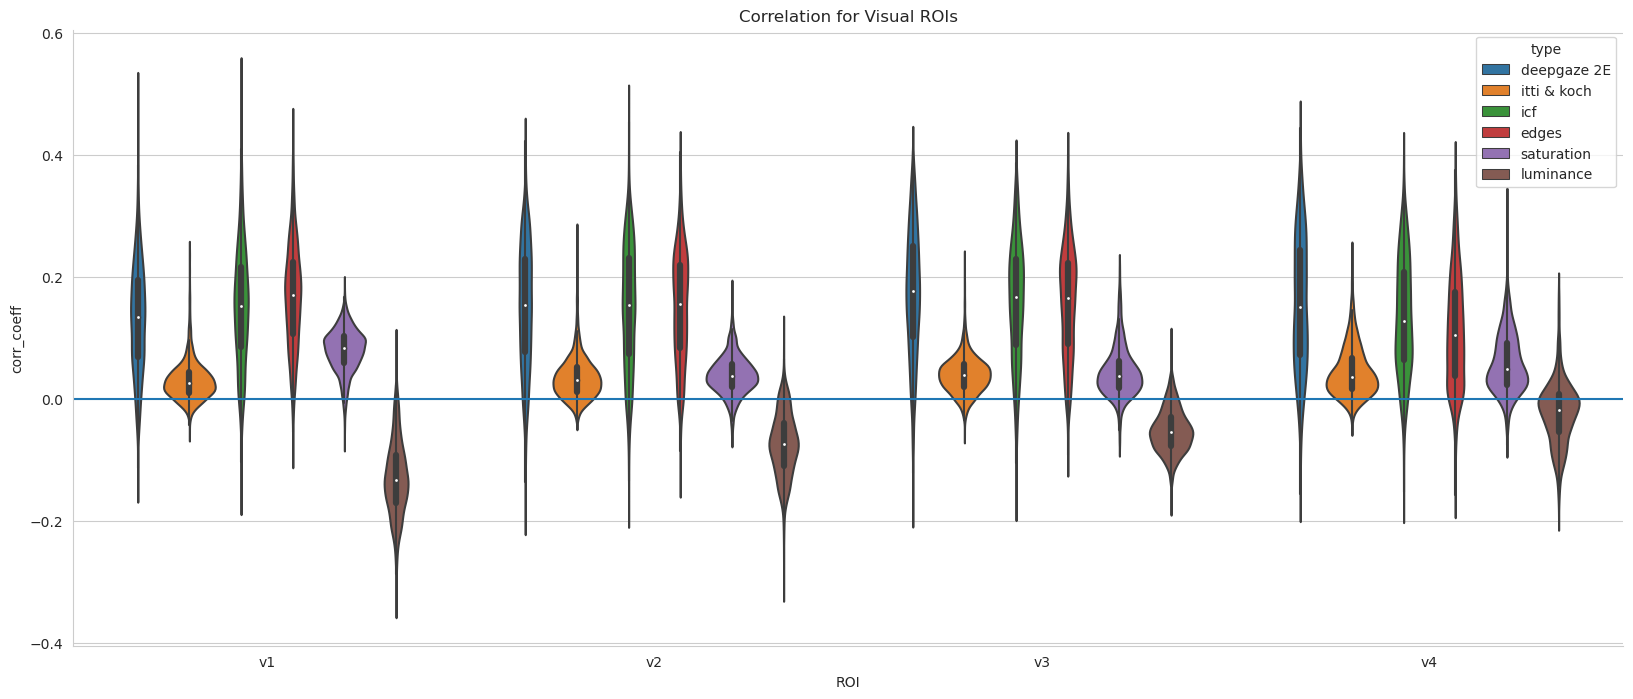

In [129]:
plt.figure(figsize=(20, 8))

plot_corr_violinplot(df = concat_df_with_type(
                          df_list = [corr_df_viz, corr_df_viz_itti, corr_df_viz_icf, corr_df_viz_edges, corr_df_viz_saturation, corr_df_viz_luminance],
                        type_list = ["deepgaze 2E", "itti & koch" , "icf", "edges", "saturation", "luminance"]),                   
                            title = "Correlation for Visual ROIs",
                            palette = "tab10")

### Deepgaze 2

In [132]:
S_mat_dg2_averaged = gen_avg_sal_maps('deepgaze2')

100%|██████████| 30000/30000 [00:30<00:00, 987.31it/s] 


In [134]:
corr_df_viz_dg2 = generate_corr_full(viz_roi_list,S_mat_dg2_averaged, print_log = False)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



In [136]:
corr_df_faces_dg2 = generate_corr_full(floc_faces_roi_list,S_mat_dg2_averaged, print_log = False)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [137]:
corr_df_bodies_dg2 = generate_corr_full(floc_bodies_roi_list,S_mat_dg2_averaged, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



In [138]:
corr_df_places_dg2 = generate_corr_full(floc_places_roi_list,S_mat_dg2_averaged, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



In [139]:
corr_df_words_dg2 = generate_corr_full(floc_words_roi_list,S_mat_dg2_averaged, print_log = False)

Computing correlation for eba

Computing correlation for fba1

Computing correlation for fba2



In [140]:
corr_df_listA_dg2 = generate_corr_full(list_a, S_mat_dg2_averaged, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



In [141]:
corr_df_listB_dg2 = generate_corr_full(list_b, S_mat_dg2_averaged, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



### GBVS 

In [142]:
S_mat_gbvs_averaged = gen_avg_sal_maps('gbvs')

 92%|█████████▏| 27664/30000 [02:41<00:02, 1140.13it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [02:42<00:00, 185.09it/s] 


In [143]:
corr_df_viz_gbvs = generate_corr_full(viz_roi_list,S_mat_gbvs_averaged, print_log = False)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



In [144]:
corr_df_faces_gbvs = generate_corr_full(floc_faces_roi_list,S_mat_gbvs_averaged, print_log = False)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [145]:
corr_df_bodies_gbvs = generate_corr_full(floc_bodies_roi_list,S_mat_gbvs_averaged, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



In [146]:
corr_df_places_gbvs = generate_corr_full(floc_places_roi_list,S_mat_gbvs_averaged, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



In [147]:
corr_df_words_gbvs = generate_corr_full(floc_words_roi_list,S_mat_gbvs_averaged, print_log = False)

Computing correlation for eba

Computing correlation for fba1

Computing correlation for fba2



In [148]:
corr_df_listA_gbvs = generate_corr_full(list_a, S_mat_gbvs_averaged, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



In [149]:
corr_df_listB_gbvs = generate_corr_full(list_b, S_mat_gbvs_averaged, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



In [168]:
corr_dfs_gbvs = {} 

corr_dfs_gbvs['viz'] = corr_df_viz_gbvs
corr_dfs_gbvs['faces'] = corr_df_faces_gbvs
corr_dfs_gbvs['words'] = corr_df_words_gbvs
corr_dfs_gbvs['places']= corr_df_places_gbvs
corr_dfs_gbvs['bodies']= corr_df_bodies_gbvs
corr_dfs_gbvs['list_a']= corr_df_listA_gbvs
corr_dfs_gbvs['list_b']= corr_df_listB_gbvs

pickle.dump(corr_dfs_gbvs, open(f"{DATA_PATH}/corr_dictionaries/corr_dfs_gbvs.pkl", "wb"))

### DeepGaze 1 

In [167]:
S_mat_dg1_averaged = gen_avg_sal_maps('deepgaze1')

 92%|█████████▏| 27605/30000 [00:12<00:00, 6897.94it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:12<00:00, 2393.02it/s]


In [169]:
corr_df_viz_dg1 = generate_corr_full(viz_roi_list,S_mat_dg1_averaged, print_log = False)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



In [171]:
corr_df_faces_dg1 = generate_corr_full(floc_faces_roi_list,S_mat_dg1_averaged, print_log = False)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [172]:
corr_df_bodies_dg1 = generate_corr_full(floc_bodies_roi_list,S_mat_dg1_averaged, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



In [173]:
corr_df_places_dg1 = generate_corr_full(floc_places_roi_list,S_mat_dg1_averaged, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



In [174]:
corr_df_words_dg1 = generate_corr_full(floc_words_roi_list,S_mat_dg1_averaged, print_log = False)

Computing correlation for eba

Computing correlation for fba1

Computing correlation for fba2



In [175]:
corr_df_listA_dg1 = generate_corr_full(list_a, S_mat_dg1_averaged, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



In [176]:
corr_df_listB_dg1 = generate_corr_full(list_b, S_mat_dg1_averaged, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



## Plot graphs

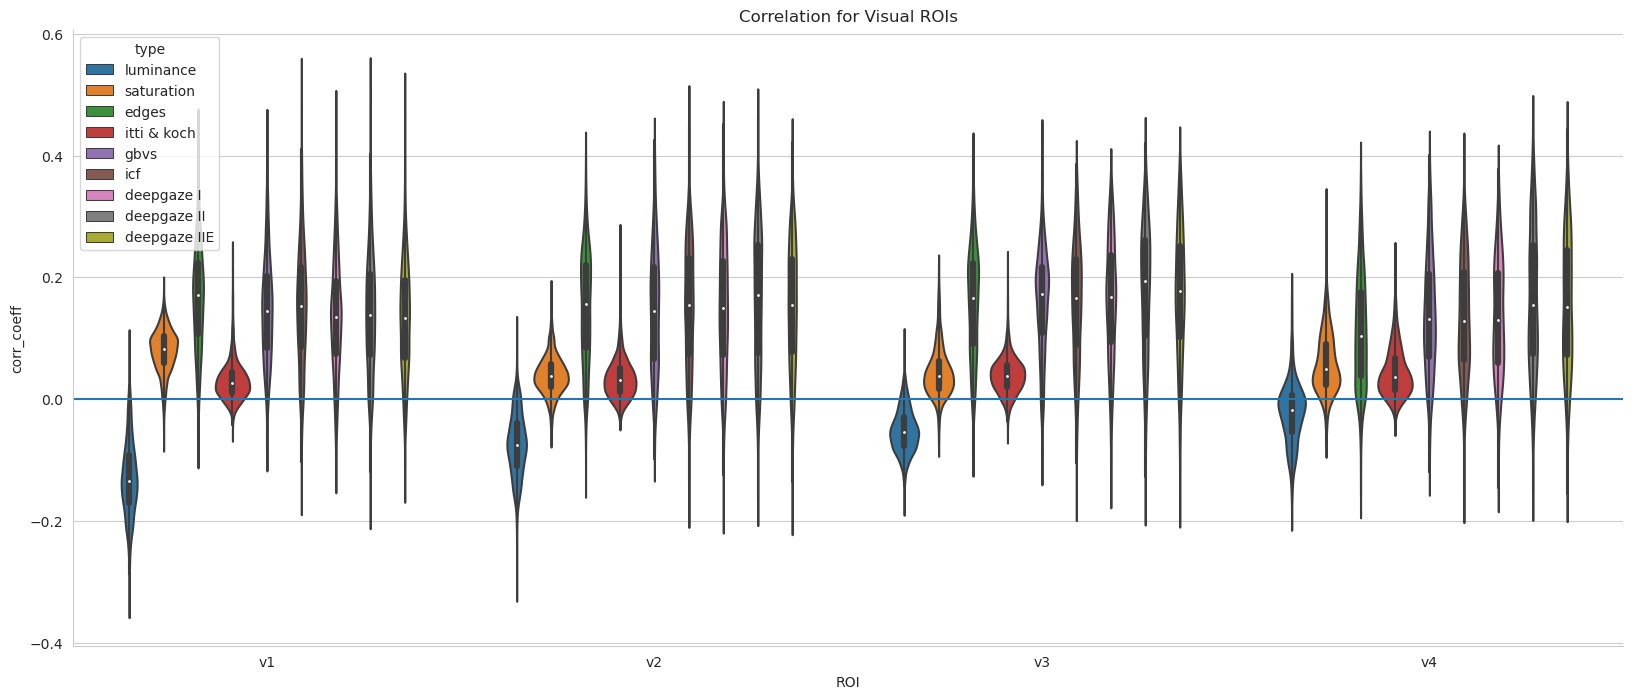

In [181]:
plt.figure(figsize=(20, 8))

plot_corr_violinplot(df = concat_df_with_type(
                          df_list = [corr_df_viz, corr_df_viz_itti, corr_df_viz_gbvs, corr_df_viz_icf, corr_df_viz_dg2,corr_df_viz_dg1, corr_df_viz_edges, corr_df_viz_saturation, corr_df_viz_luminance],
                        type_list = ["deepgaze IIE", "itti & koch" ,"gbvs","icf","deepgaze II","deepgaze I", "edges", "saturation", "luminance"]), 
                     
                         hue_order = ['luminance', 'saturation', 'edges', 'itti & koch', 'gbvs', 'icf', 'deepgaze I', 'deepgaze II', 'deepgaze IIE'],
                            title = "Correlation for Visual ROIs",
                            palette = "tab10")

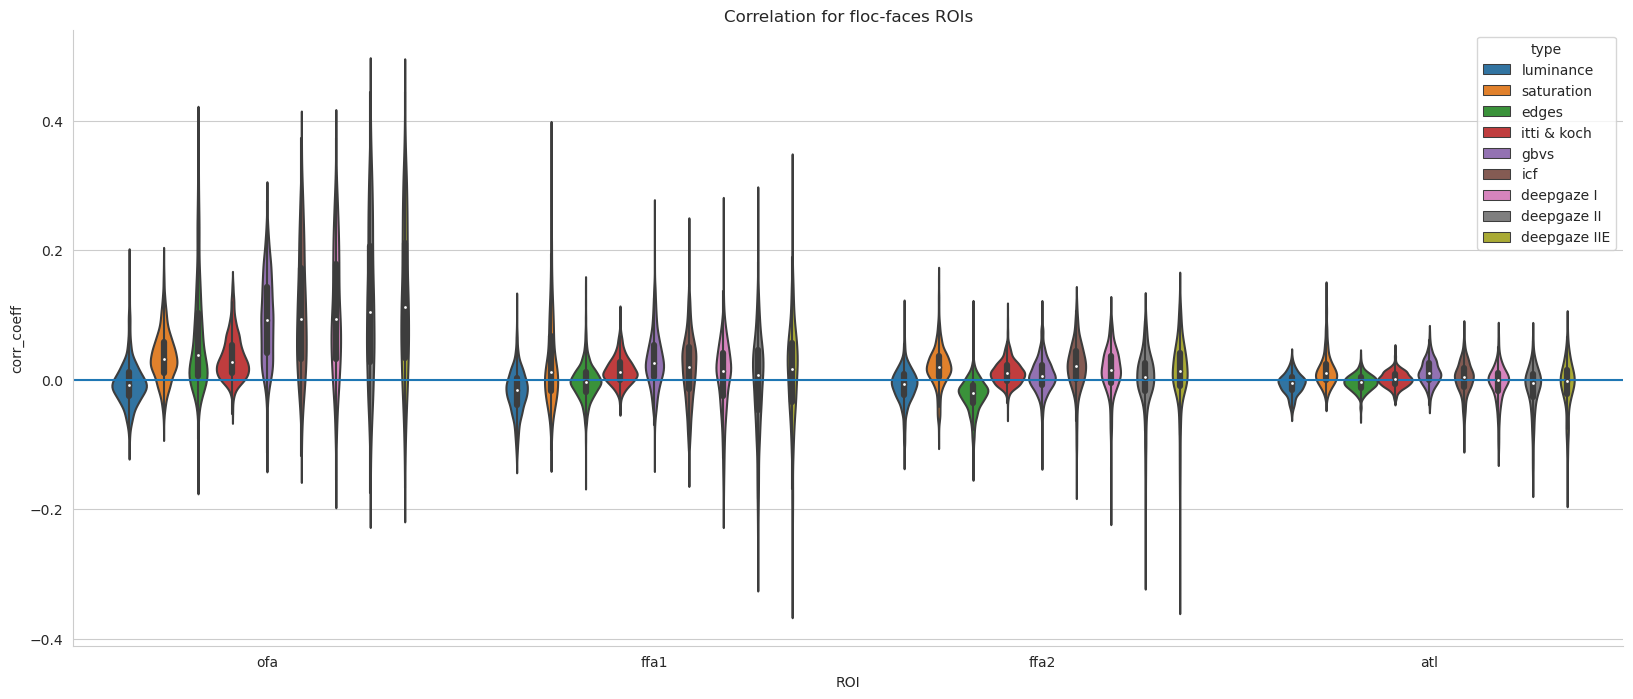

In [190]:
plt.figure(figsize=(20, 8))

plot_corr_violinplot(df = concat_df_with_type(
                          df_list = [corr_df_faces, corr_df_faces_itti, corr_df_faces_gbvs, corr_df_faces_icf, corr_df_faces_dg2, corr_df_faces_dg1, corr_df_faces_edges, corr_df_faces_saturation, corr_df_faces_luminance],
                        type_list = ["deepgaze IIE", "itti & koch" ,"gbvs","icf","deepgaze II","deepgaze I", "edges", "saturation", "luminance"]), 
                     
                         hue_order = ['luminance', 'saturation', 'edges', 'itti & koch', 'gbvs', 'icf', 'deepgaze I', 'deepgaze II', 'deepgaze IIE'],           
                            title = "Correlation for floc-faces ROIs",
                            palette = "tab10")

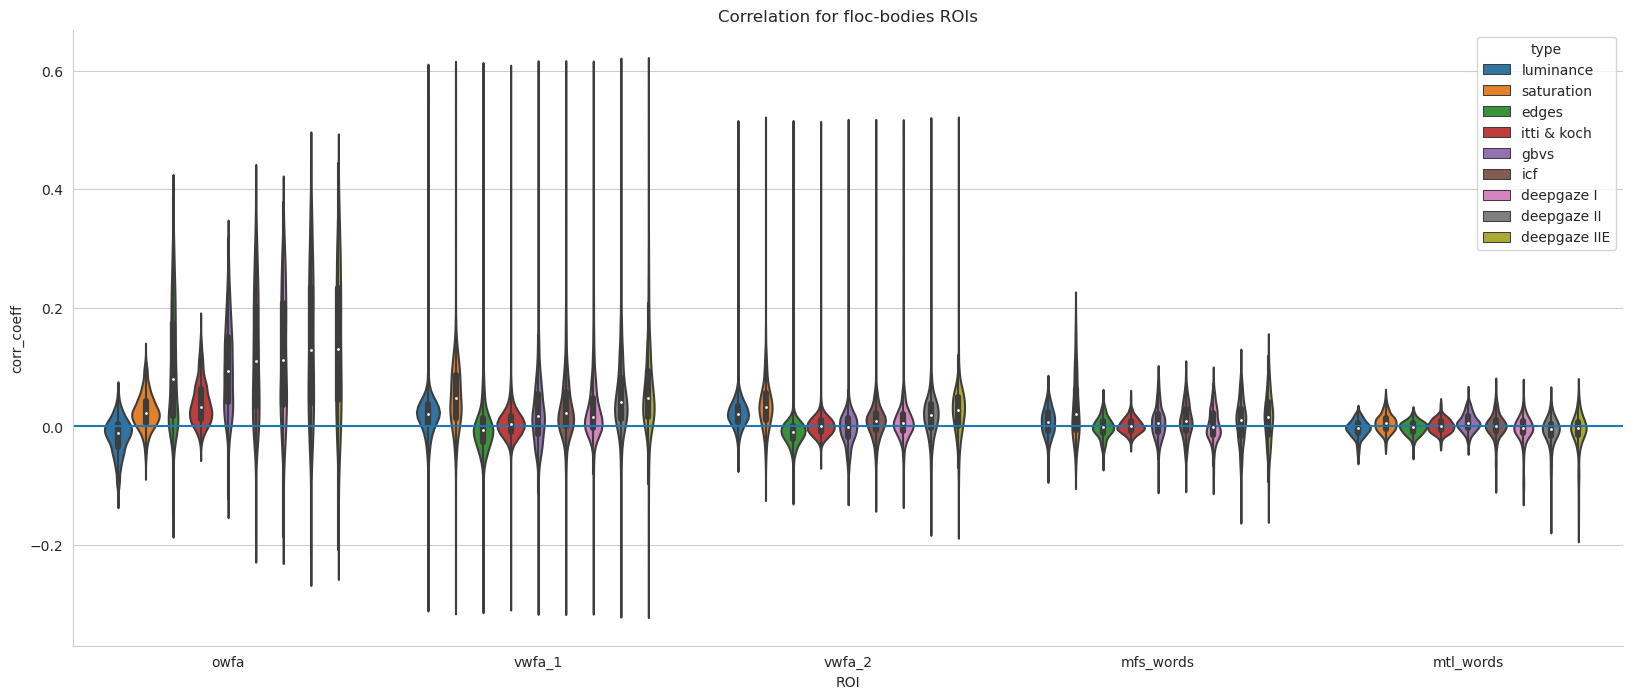

In [191]:
plt.figure(figsize=(20, 8))

plot_corr_violinplot(df = concat_df_with_type(
                          df_list = [corr_df_bodies, corr_df_bodies_itti, corr_df_bodies_gbvs, corr_df_bodies_icf, corr_df_bodies_dg2, corr_df_bodies_dg1 , corr_df_bodies_edges, corr_df_bodies_saturation, corr_df_bodies_luminance],
                        type_list = ["deepgaze IIE", "itti & koch" ,"gbvs","icf","deepgaze II","deepgaze I", "edges", "saturation", "luminance"]), 
                     
                         hue_order = ['luminance', 'saturation', 'edges', 'itti & koch', 'gbvs', 'icf', 'deepgaze I', 'deepgaze II', 'deepgaze IIE'],              
                            title = "Correlation for floc-bodies ROIs",
                            palette = "tab10")

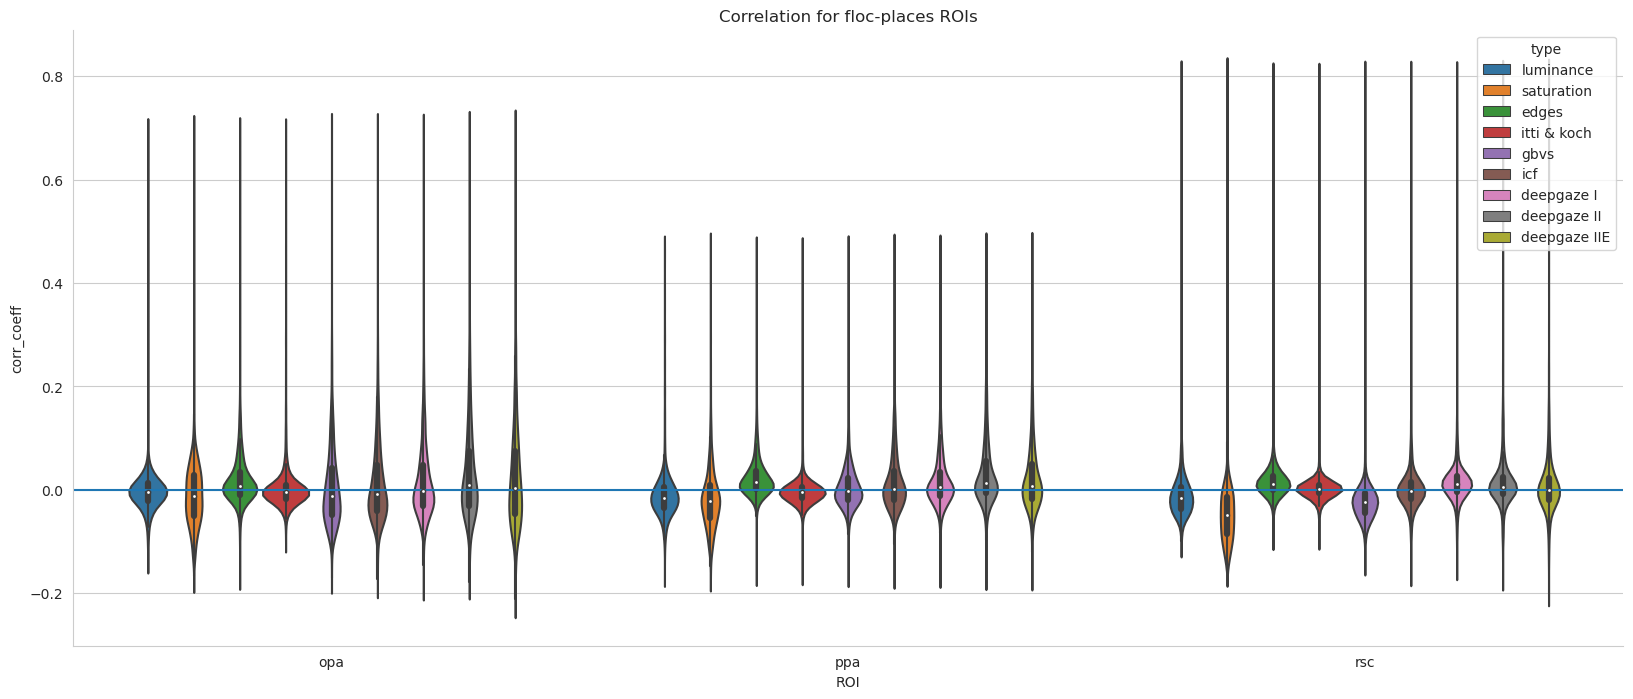

In [192]:
plt.figure(figsize=(20, 8))

plot_corr_violinplot(df = concat_df_with_type(
                          df_list = [corr_df_places, corr_df_places_itti, corr_df_places_gbvs, corr_df_places_icf, corr_df_places_dg2, corr_df_places_dg1, corr_df_places_edges, corr_df_places_saturation, corr_df_places_luminance],
                         type_list = ["deepgaze IIE", "itti & koch" ,"gbvs","icf","deepgaze II","deepgaze I", "edges", "saturation", "luminance"]), 
                     
                         hue_order = ['luminance', 'saturation', 'edges', 'itti & koch', 'gbvs', 'icf', 'deepgaze I', 'deepgaze II', 'deepgaze IIE'],                 
                            title = "Correlation for floc-places ROIs",
                            palette = "tab10")

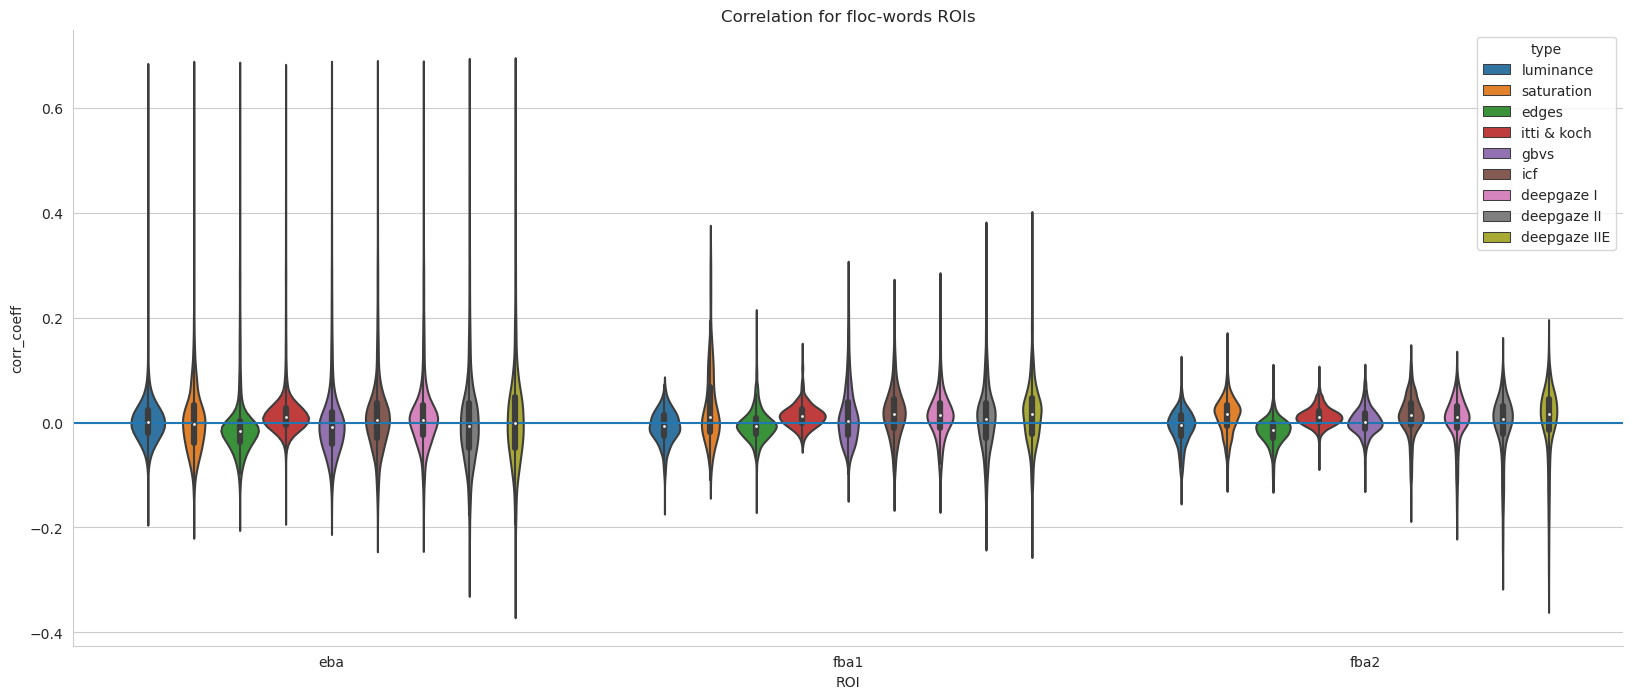

In [193]:
plt.figure(figsize=(20, 8))

plot_corr_violinplot(df = concat_df_with_type(
                          df_list = [corr_df_words, corr_df_words_itti, corr_df_words_gbvs, corr_df_words_icf, corr_df_words_dg2, corr_df_words_dg1,corr_df_words_edges, corr_df_words_saturation, corr_df_words_luminance],
                        type_list = ["deepgaze IIE", "itti & koch" ,"gbvs","icf","deepgaze II","deepgaze I", "edges", "saturation", "luminance"]), 
                     
                         hue_order = ['luminance', 'saturation', 'edges', 'itti & koch', 'gbvs', 'icf', 'deepgaze I', 'deepgaze II', 'deepgaze IIE'],                 
                            title = "Correlation for floc-words ROIs",
                            palette = "tab10")

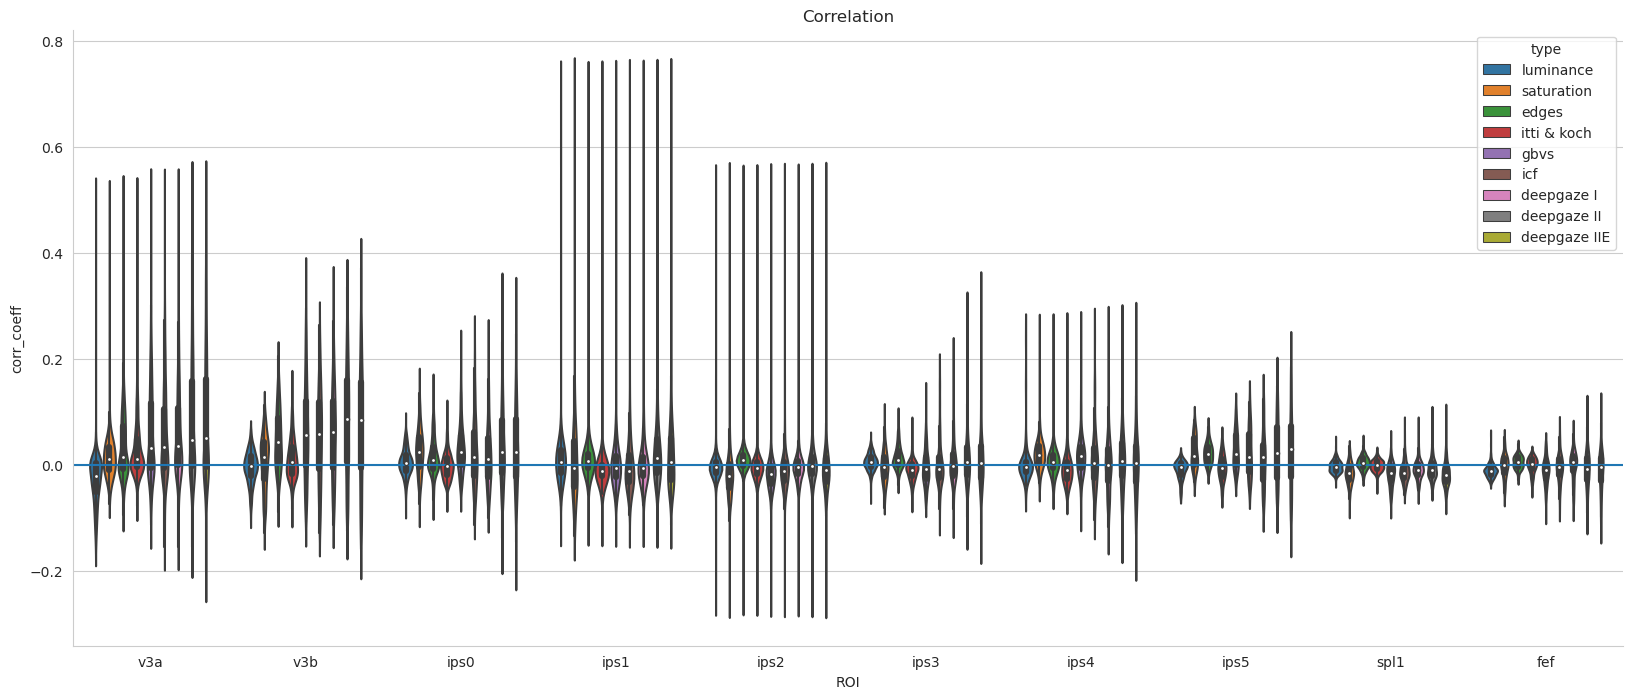

In [194]:
plt.figure(figsize=(20, 8))

plot_corr_violinplot(df = concat_df_with_type(
                          df_list = [corr_df_list_a, corr_df_listA_itti, corr_df_listA_gbvs, corr_df_listA_icf, corr_df_listA_dg2, corr_df_listA_dg1, corr_df_listA_edges, corr_df_listA_saturation, corr_df_listA_luminance],
                        type_list = ["deepgaze IIE", "itti & koch" ,"gbvs","icf","deepgaze II","deepgaze I", "edges", "saturation", "luminance"]), 
                     
                         hue_order = ['luminance', 'saturation', 'edges', 'itti & koch', 'gbvs', 'icf', 'deepgaze I', 'deepgaze II', 'deepgaze IIE'],         
                            title = "Correlation",
                            palette = "tab10")

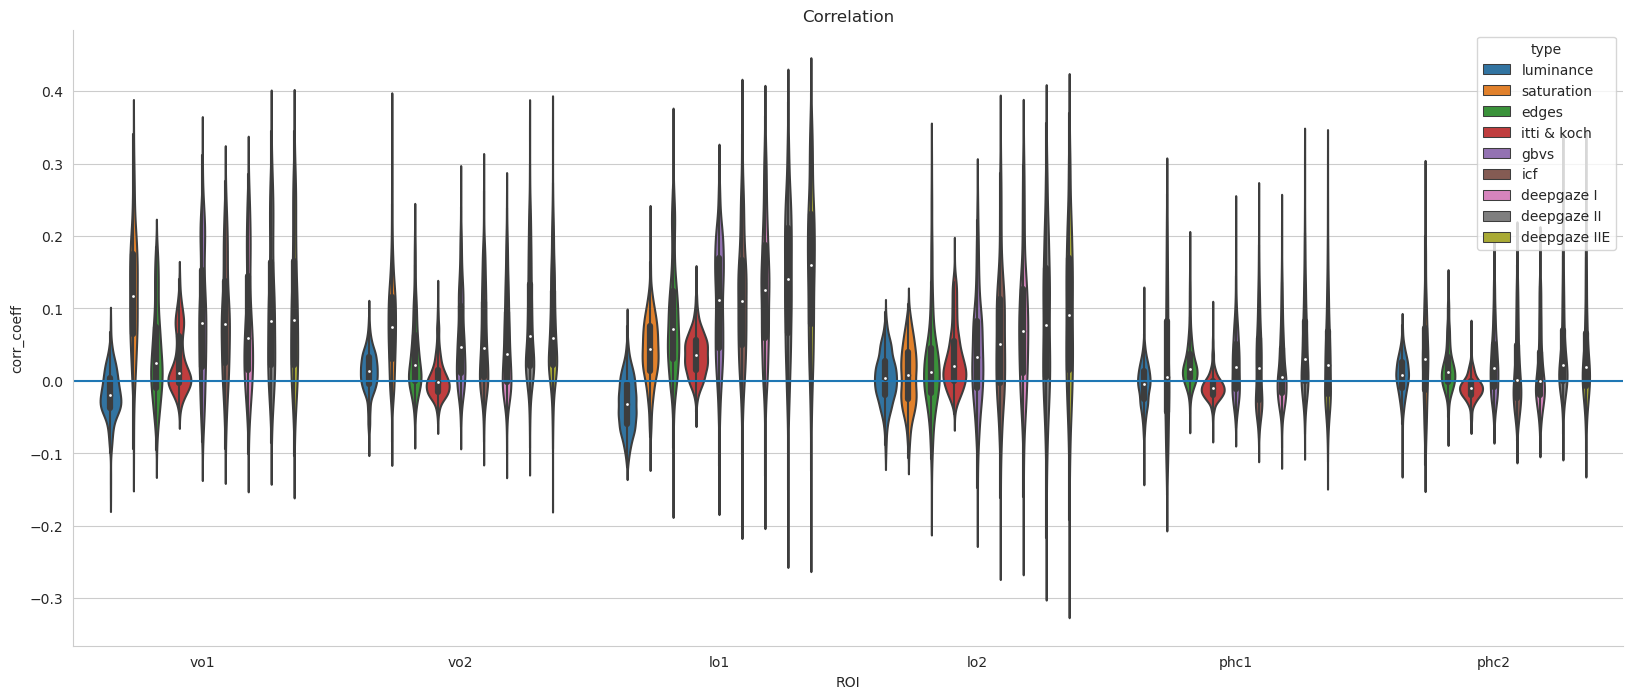

In [195]:
plt.figure(figsize=(20, 8))

plot_corr_violinplot(df = concat_df_with_type(
                          df_list = [corr_df_list_b, corr_df_listB_itti, corr_df_listB_gbvs, corr_df_listB_icf, corr_df_listB_dg2,corr_df_listB_dg1, corr_df_listB_edges, corr_df_listB_saturation, corr_df_listB_luminance],
                        type_list = ["deepgaze IIE", "itti & koch" ,"gbvs","icf","deepgaze II","deepgaze I", "edges", "saturation", "luminance"]), 
                     
                         hue_order = ['luminance', 'saturation', 'edges', 'itti & koch', 'gbvs', 'icf', 'deepgaze I', 'deepgaze II', 'deepgaze IIE'],             
                            title = "Correlation",
                            palette = "tab10")

# Using spatial structure to get an accuracy metric for models 

We currently ignore the spatial structure of the predicted voxel response. Instead of correlating predicted and observed voxel time series, we can proceed image-by-image and apply an accuracy metric that compares the two vectors. 

In [127]:
def get_pred_and_observed_betas(roi, S_mat):
    
    num_pixels = 425 
    
    # print(f"Computing for {roi}\n")

    K_mat = np.load(DATA_PATH+f"/K_mat_subj1_{roi}.npy.npz")
    K_mat = K_mat['arr_0']
    
    betas_mat = np.load(averaged_beta_files_path+f"/betas_full_avg_{roi}.npy")
          
    roi_valid_indices = np.load(DATA_PATH+f"/{roi}_valid_indices_subj{subject}.npy")
    
    # index the betas for the corresponding voxels that are valid 
    betas_val = betas_mat[:,roi_valid_indices] 

    # TODO # Remove the voxels that were NaN for the  (DONE AFTER TAKING VALID INDICES)
    roi_non_zero_voxel_mask = np.load(DATA_PATH+f"/non_zero_voxel_mask_subj{subject}_{roi}.npy")
    
    # since the K had invalid rows removed from it , we need to remove the same rows from beta so that their shapes match 
    betas_val = betas_val[:, roi_non_zero_voxel_mask]                   
    
    if S_mat.ndim !=2: # This means that the S_mat has not been unrolled 
        S_mat = S_mat.reshape(-1, num_pixels * num_pixels)
        
    # Remove NaN rows if present from both Betas and S_mat
    nan_rows = np.isnan(betas_val).any(axis = 1) 
    betas_val = betas_val[~nan_rows]
    S_mat = S_mat[~nan_rows]
     
    
    Y_hat = S_mat @ K_mat.T

    return Y_hat, betas_val

In [ ]:
Y_hat_v1_dg , betas_v1 = get_pred_and_observed_betas('v1', S_mat_averaged) 

In [28]:
Y_hat_v1_dg.shape,  betas_v1.shape

((9841, 4165), (9841, 4165))

In [26]:
def get_similarity_cosine_2d(A,B):
    '''
    Calculate the cosine similarity of two 2D matrices A and B 
    '''
    cosine = np.sum(A*B, axis=1)/(norm(A, axis=1)*norm(B, axis=1))
    
    return cosine

In [37]:
def get_similarity_r2(A,B):
    '''
    Calculate the coefficient of determinant of two 2D matrices A and B 
    '''
    
    # A and B are of shape num_imgs x num_voxels 
    # we want to take the correlation across voxels within each image and then take mean across images for the specific ROI 
    
    
    # corr_matrix = np.corrcoef(A,B) # Since the rows (images) are the variables 
    
    corr_dict = {} 
    
    for row_idx in range(A.shape[0]): # Loop over the voxel response per image
        obs_for_img = A[row_idx]
        pred_for_img = B[row_idx]
        
        corr_for_img = np.corrcoef(obs_for_img, pred_for_img)
        
        corr_dict[row_idx] = corr_for_img[0,1]
     
    return corr_dict

In [61]:
def generate_similarity_all_rois(model, distance):
    num_pixels = 425 
    num_images = 30000
    
    if model == 'deepgaze':
        S_mat_file_name = "S_mat_averaged.npy"
        
    elif model == 'edges':
        S_mat_file_name = "S_mat_edges_averaged.npy"
        
    elif model == 'luminance':
        S_mat_file_name = "S_mat_luminance_averaged.npy"
        
    elif model == 'saturation':
        S_mat_file_name = "S_mat_saturation_averaged.npy"
        
    elif model == 'ittikoch':
        S_mat_file_name = "S_mat_ittikoch_averaged.npy" 
    else:
        raise Exception("Argument 'model' must be either 'deepgaze', 'edges', 'luminance' , 'saturation' or 'ittikoch'. ")
    
    
    
    S_mat = np.load(DATA_PATH+f"/averaged_beta_files/{S_mat_file_name}")
    
    rois = ["v1", "v2","v3","v4",
            "ofa","ffa1", "ffa2", "atl",
            "eba","fba1", "fba2",
            "opa", "ppa", "rsc",
            "owfa", "vwfa_1", "vwfa_2", "mfs_words", "mtl_words",

            "vo1","vo2","phc1","phc2","mst","hmt","lo2","lo1",
            "v3b","v3a","ips0","ips1","ips2","ips3","ips4",
            "ips5","spl1","fef"]
    
    similarities_rois = {} 
    
    
    for roi in tqdm(rois):
        pred, obs = get_pred_and_observed_betas(roi, S_mat) 
        
        if distance == 'cosine':
            similarity = get_similarity_cosine_2d(pred,obs)
        elif distance == 'r2':
            similarity = get_similarity_r2(pred,obs)
        
        similarities_rois[roi] = similarity
        
    
    return similarities_rois
   
    


In [128]:
corr_sim_deepgaze = generate_similarity_all_rois('deepgaze','r2')

100%|██████████| 37/37 [44:34<00:00, 72.30s/it]  


In [227]:
spatial_corr_files_path = DATA_PATH + "/spatial_corr_files/"

In [228]:
np.save(spatial_corr_files_path+"corr_sim_deepgaze", corr_sim_deepgaze)

In [129]:
corr_sim_edges = generate_similarity_all_rois('edges','r2')

100%|██████████| 37/37 [34:51<00:00, 56.53s/it]


In [229]:
np.save(spatial_corr_files_path+"corr_sim_edges", corr_sim_edges)

In [196]:
corr_sim_luminance = generate_similarity_all_rois('luminance','r2')

100%|██████████| 37/37 [45:49<00:00, 74.32s/it]  


In [230]:
np.save(spatial_corr_files_path+"corr_sim_luminance", corr_sim_luminance)

In [197]:
corr_sim_saturation = generate_similarity_all_rois('saturation','r2')

  0%|          | 0/37 [00:00<?, ?it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 37/37 [44:28<00:00, 72.12s/it]  


In [231]:
np.save(spatial_corr_files_path+"corr_sim_saturation", corr_sim_saturation)

In [198]:
corr_sim_ittikoch = generate_similarity_all_rois('ittikoch','r2')

100%|██████████| 37/37 [29:43<00:00, 48.20s/it]


In [232]:
np.save(spatial_corr_files_path+"corr_sim_ittikoch", corr_sim_ittikoch)

In [112]:
def generate_mean_corrs_from_r2(corr_dict):
    mean_vals = {} 
    ul_vals = {} 
    ll_vals = {} 

    for roi, _ in tqdm(corr_dict.items()): 

        corrs = list(corr_dict[roi].values())
        corrs_z = np.arctanh(corrs)
        mn_corrs_z = np.mean(corrs_z)
        sem_corrs_z = np.std(corrs_z) / np.sqrt(len(corrs_z))
        ci_ul_corrs_z = mn_corrs_z + sem_corrs_z
        ci_ll_corrs_z = mn_corrs_z - sem_corrs_z
        mean_corr = np.tanh(mn_corrs_z)
        ci_ul_corrs = np.tanh(ci_ul_corrs_z)
        ci_ll_corrs = np.tanh(ci_ll_corrs_z)
        
        # mean_corr = np.tanh(np.mean(np.arctanh(corrs)))

        mean_vals[roi] = mean_corr
        ul_vals[roi] = ci_ul_corrs
        ll_vals[roi] = ci_ll_corrs
        
    
    return mean_vals, ul_vals, ll_vals

In [131]:
mean_corr_dg, ul_corr_dg, ll_corr_dg = generate_mean_corrs_from_r2(corr_sim_deepgaze)

100%|██████████| 37/37 [00:00<00:00, 843.96it/s]


In [161]:
mean_corr_edges, ul_corr_edges, ll_corr_edges = generate_mean_corrs_from_r2(corr_sim_edges)

100%|██████████| 37/37 [00:00<00:00, 917.16it/s]


In [200]:
mean_corr_lum, ul_corr_lum, ll_corr_lum = generate_mean_corrs_from_r2(corr_sim_luminance)

100%|██████████| 37/37 [00:00<00:00, 826.45it/s]


In [203]:
mean_corr_sat, ul_corr_sat, ll_corr_sat = generate_mean_corrs_from_r2(corr_sim_saturation)

100%|██████████| 37/37 [00:00<00:00, 789.71it/s]


In [204]:
mean_corr_ittikoch, ul_corr_ittikoch, ll_corr_ittikoch = generate_mean_corrs_from_r2(corr_sim_ittikoch)

100%|██████████| 37/37 [00:00<00:00, 853.58it/s]


In [158]:
def generate_unified_dict_for_means(mean_dict, upperlimit_dict, lowerlimit_dict):
    
    corr_vals_dict = {} 
    
    corr_vals_dict['mean'] = mean_dict
    corr_vals_dict['upper_limit'] = upperlimit_dict
    corr_vals_dict['lower_limit'] = lowerlimit_dict
    
    return corr_vals_dict

In [159]:
corr_vals_dict_dg = generate_unified_dict_for_means(mean_corr_dg, ul_corr_dg, ll_corr_dg)

In [162]:
corr_vals_dict_edges = generate_unified_dict_for_means(mean_corr_edges, ul_corr_edges, ll_corr_edges)

In [201]:
corr_vals_dict_luminance = generate_unified_dict_for_means(mean_corr_lum, ul_corr_lum, ll_corr_lum)

In [205]:
corr_vals_dict_saturation = generate_unified_dict_for_means(mean_corr_sat, ul_corr_sat, ll_corr_sat)

In [206]:
corr_vals_dict_ittikoch = generate_unified_dict_for_means(mean_corr_ittikoch, ul_corr_ittikoch, ll_corr_ittikoch)

In [239]:
def plot_means_and_error_modelwise(roi_list, model_list, model_names,title): 
    
    
    # Initialize lists for means, upper limits, and lower limits for each model
    num_models = len(model_list)
    x = np.arange(len(roi_list))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot each dataset
    for i, dataset in enumerate(model_list):
        means, upper_limits, lower_limits = [], [], []

        # Populate the lists for the current dataset
        for roi in roi_list:
            means.append(dataset['mean'].get(roi, 0))
            upper_limits.append(dataset['upper_limit'].get(roi, 0))
            lower_limits.append(dataset['lower_limit'].get(roi, 0))

        # Offset the x-position to separate datasets
        offset = 0.2 * (i - (num_models - 1) / 2)

        # Plot the means as points with error bars for the current dataset
        ax.errorbar(x + offset, means, yerr=[lower_limits, upper_limits], fmt='o', capsize=5, label=f'{model_names[i]}', linestyle='None')
        
    ax.set_xticks(x)
    ax.set_xticklabels(roi_list)

    ax.set_xlabel('ROI')
    ax.set_ylabel('Mean')
    ax.set_title(title)
    ax.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [240]:
viz_roi_list = ["v1","v2","v3","v4"]
floc_faces_roi_list = ["ofa","ffa1", "ffa2", "atl"]
floc_words_roi_list = ["eba","fba1", "fba2"]
floc_places_roi_list = ["opa", "ppa", "rsc"]
floc_bodies_roi_list = ["owfa", "vwfa_1", "vwfa_2", "mfs_words", "mtl_words"]

ventral_temporal_roi_list = ["vo1","vo2","phc1","phc2"]
dorso_lateral_roi_list = ["v3a","v3b","lo2","lo1"]
pareital_frontal_roi_list = ["ips0","ips1","ips2","ips3","ips4","ips5","spl1","fef"]
       
list_a = ["v3a","v3b", "ips0","ips1","ips2","ips3","ips4","ips5", "spl1","fef"]
list_b = ["vo1","vo2","lo1","lo2","phc1","phc2"]

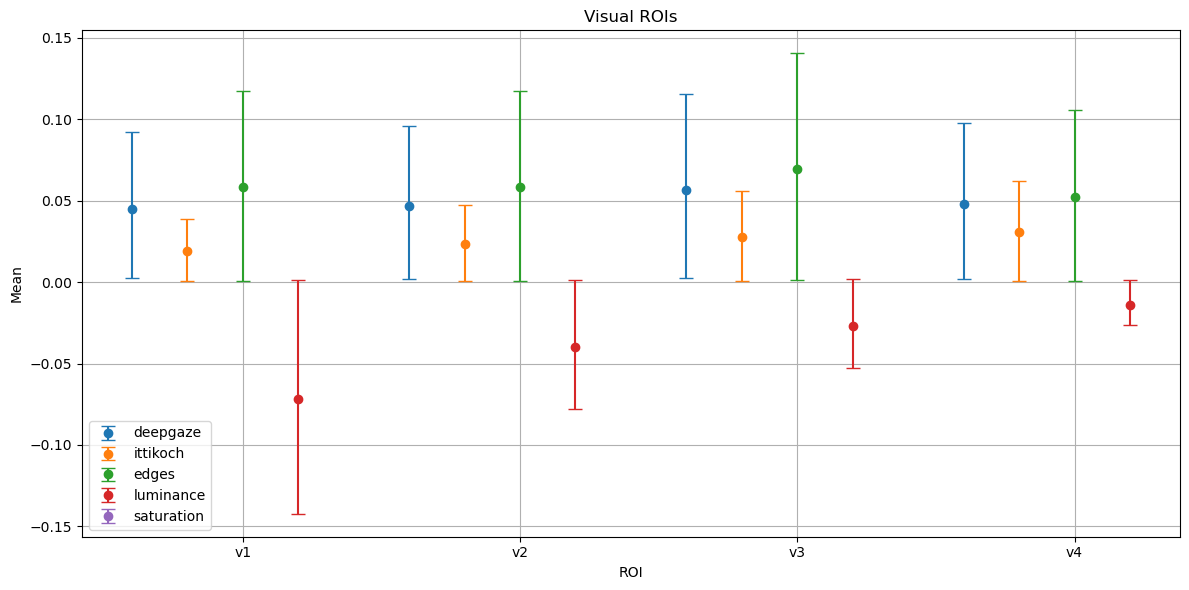

In [241]:
plot_means_and_error_modelwise(roi_list   = viz_roi_list, 
                               model_list  = [corr_vals_dict_dg, corr_vals_dict_ittikoch, corr_vals_dict_edges, corr_vals_dict_luminance, corr_vals_dict_saturation], 
                               model_names = ['deepgaze', 'ittikoch', 'edges', 'luminance', 'saturation'],
                               title = "Visual ROIs")

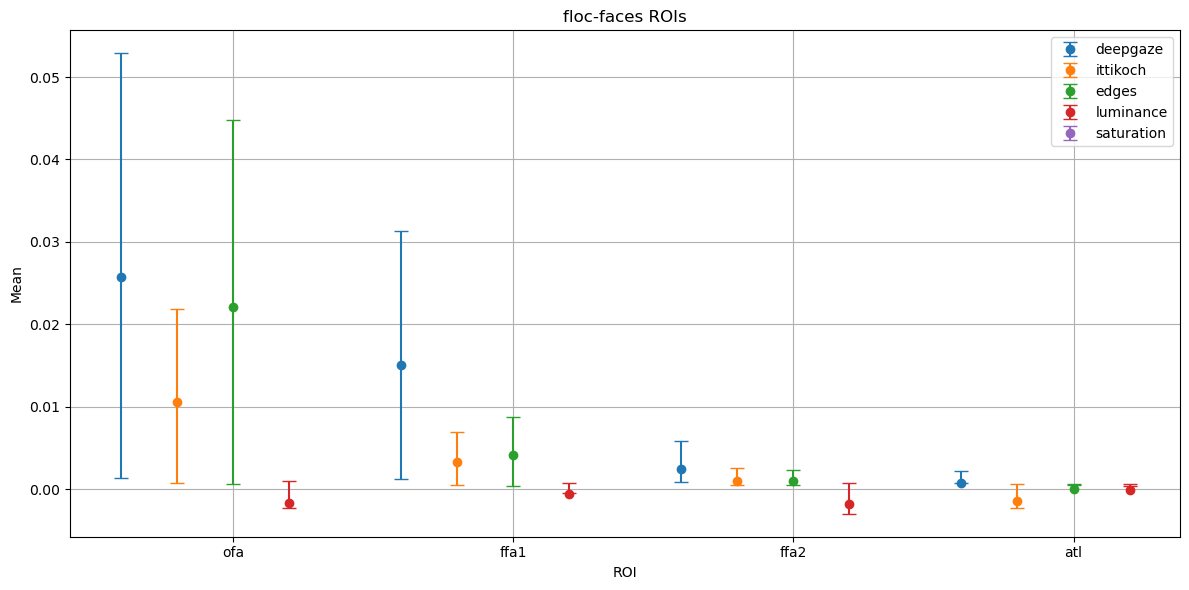

In [220]:
plot_means_and_error_modelwise(roi_list   = floc_faces_roi_list, 
                               model_list  = [corr_vals_dict_dg, corr_vals_dict_ittikoch, corr_vals_dict_edges, corr_vals_dict_luminance, corr_vals_dict_saturation], 
                               model_names = ['deepgaze', 'ittikoch', 'edges', 'luminance', 'saturation'],
                               title = "floc-faces ROIs")

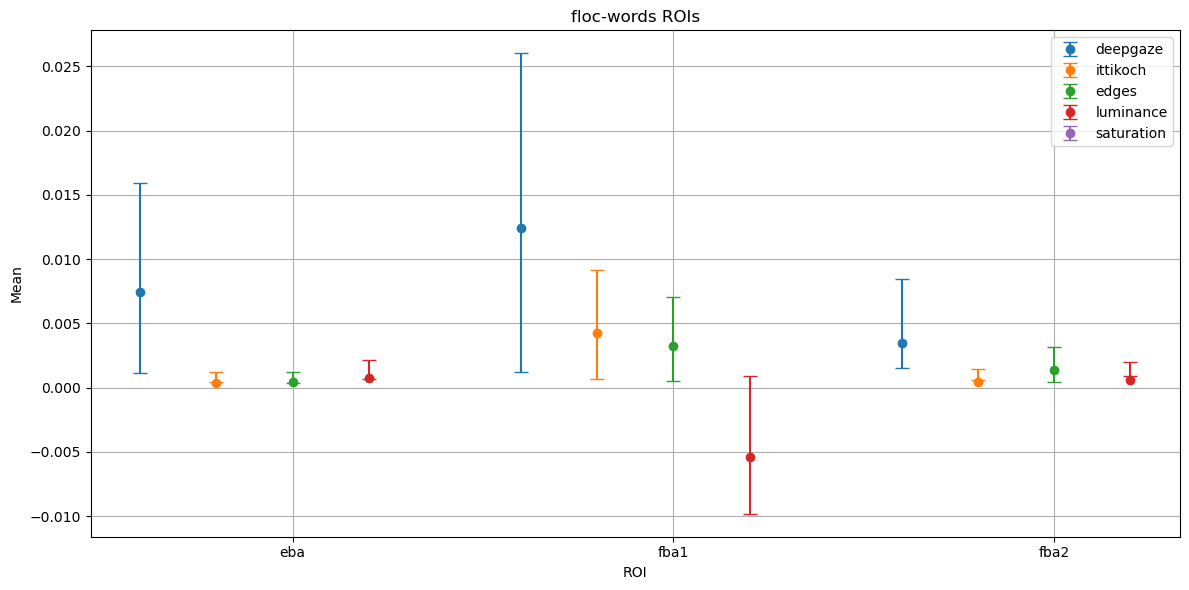

In [221]:
plot_means_and_error_modelwise(roi_list   = floc_words_roi_list, 
                               model_list  = [corr_vals_dict_dg, corr_vals_dict_ittikoch, corr_vals_dict_edges, corr_vals_dict_luminance, corr_vals_dict_saturation], 
                               model_names = ['deepgaze', 'ittikoch', 'edges', 'luminance', 'saturation'],
                               title = "floc-words ROIs")

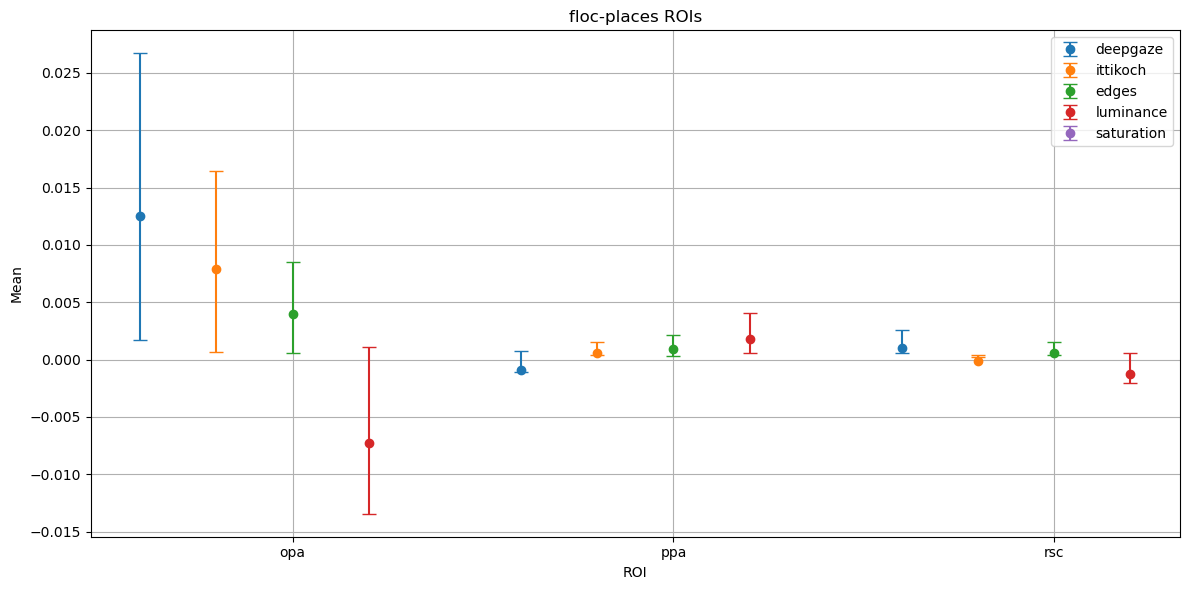

In [214]:
plot_means_and_error_modelwise(roi_list   = floc_places_roi_list, 
                               model_list  = [corr_vals_dict_dg, corr_vals_dict_ittikoch, corr_vals_dict_edges, corr_vals_dict_luminance, corr_vals_dict_saturation], 
                               model_names = ['deepgaze', 'ittikoch', 'edges', 'luminance', 'saturation'],
                               title = "floc-places ROIs")

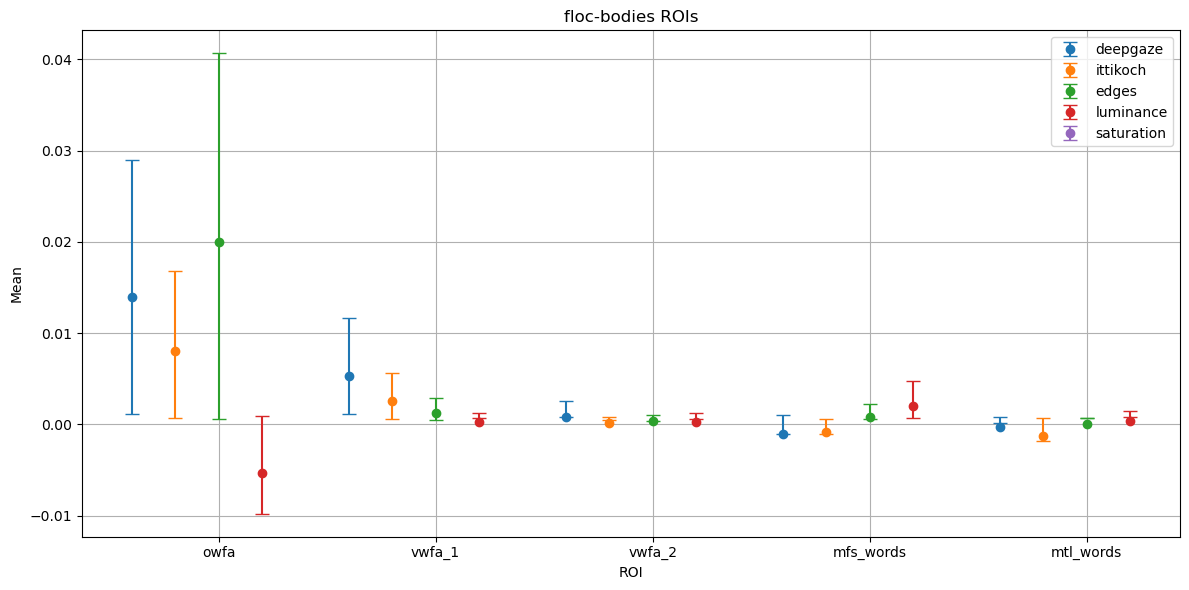

In [215]:
plot_means_and_error_modelwise(roi_list   = floc_bodies_roi_list, 
                               model_list  = [corr_vals_dict_dg, corr_vals_dict_ittikoch, corr_vals_dict_edges, corr_vals_dict_luminance, corr_vals_dict_saturation], 
                               model_names = ['deepgaze', 'ittikoch', 'edges', 'luminance', 'saturation'],
                               title = "floc-bodies ROIs")

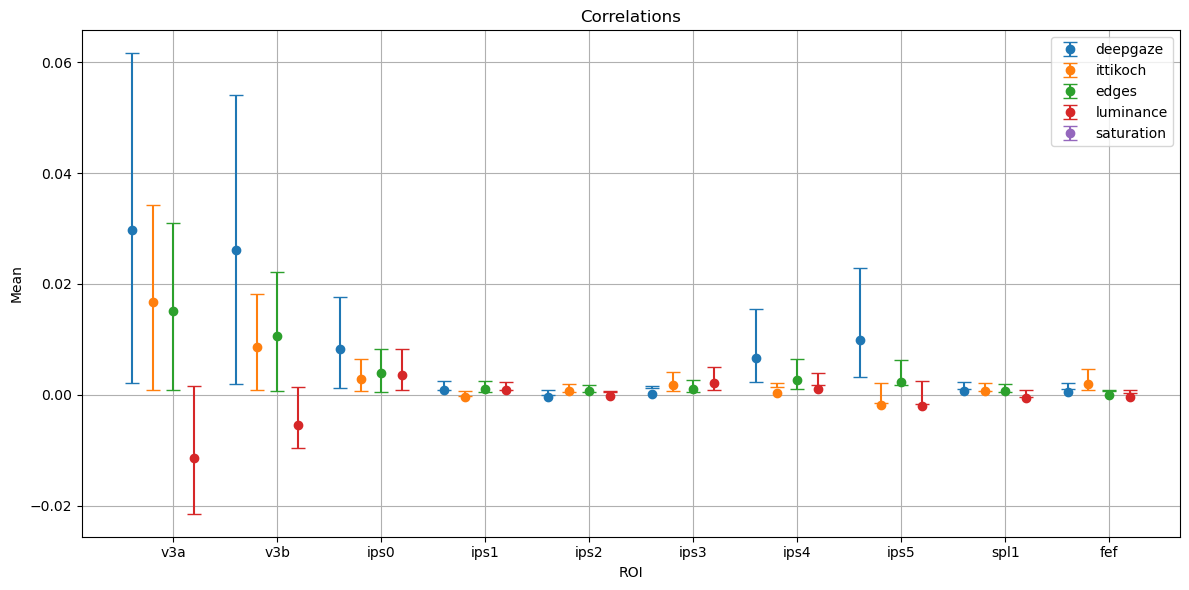

In [216]:
plot_means_and_error_modelwise(roi_list   = list_a, 
                               model_list  = [corr_vals_dict_dg, corr_vals_dict_ittikoch, corr_vals_dict_edges, corr_vals_dict_luminance, corr_vals_dict_saturation], 
                               model_names = ['deepgaze', 'ittikoch', 'edges', 'luminance', 'saturation'],
                               title = "Correlations")

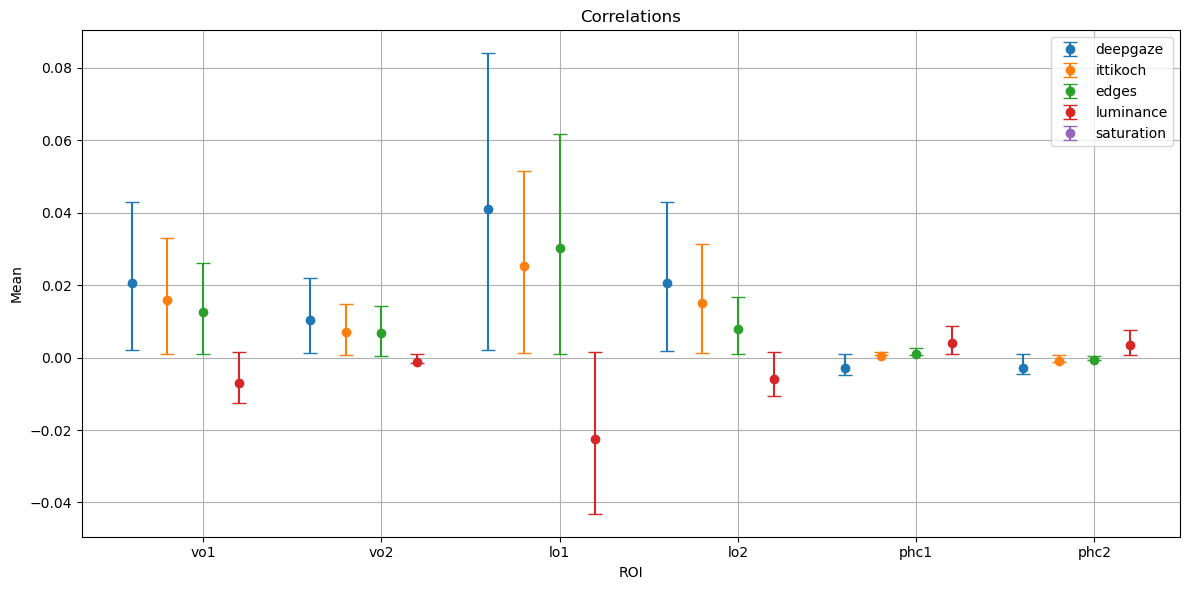

In [218]:
plot_means_and_error_modelwise(roi_list   = list_b, 
                               model_list  = [corr_vals_dict_dg, corr_vals_dict_ittikoch, corr_vals_dict_edges, corr_vals_dict_luminance, corr_vals_dict_saturation], 
                               model_names = ['deepgaze', 'ittikoch', 'edges', 'luminance', 'saturation'],
                               title = "Correlations")